### SteamGames
#### ML Assignment 1 - Sheida Majidi

In [1]:
import sys
import pandas as pd
import numpy as np
from packaging import version
import sklearn
import ast
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Get the Data

*Welcome to SteamGame Analysis! This analysis aims to to provide game developers, publishers, and industry analysts with a tool to predict and understand the factors contributing to a game's success on Steam.*

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_games_data():
    tarball_path = Path("/Users/sheidamajidi/Desktop/Winter2024/COURSES/INSY695/Individual Assignments/ML1/games.csv")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://www.kaggle.com/datasets/mexwell/steamgames/data"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as games_tarball:
            games_tarball.extractall(path="datasets")
    return pd.read_csv(Path("/Users/sheidamajidi/Desktop/Winter2024/COURSES/INSY695/Individual Assignments/ML1/games.csv"))

games = load_games_data()

## Take a Quick Look at the Data Structure

In [3]:
games.head()

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71716 entries, 0 to 71715
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AppID                       71716 non-null  int64  
 1   Name                        71715 non-null  object 
 2   Release date                71716 non-null  object 
 3   Estimated owners            71716 non-null  object 
 4   Peak CCU                    71716 non-null  int64  
 5   Required age                71716 non-null  int64  
 6   Price                       71716 non-null  float64
 7   DLC count                   71716 non-null  int64  
 8   About the game              69280 non-null  object 
 9   Supported languages         71716 non-null  object 
 10  Full audio languages        71716 non-null  object 
 11  Reviews                     9167 non-null   object 
 12  Header image                71716 non-null  object 
 13  Website                     350

In [5]:
games.columns

Index(['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU',
       'Required age', 'Price', 'DLC count', 'About the game',
       'Supported languages', 'Full audio languages', 'Reviews',
       'Header image', 'Website', 'Support url', 'Support email', 'Windows',
       'Mac', 'Linux', 'Metacritic score', 'Metacritic url', 'User score',
       'Positive', 'Negative', 'Score rank', 'Achievements', 'Recommendations',
       'Notes', 'Average playtime forever', 'Average playtime two weeks',
       'Median playtime forever', 'Median playtime two weeks', 'Developers',
       'Publishers', 'Categories', 'Genres', 'Tags', 'Screenshots', 'Movies'],
      dtype='object')

In [6]:
games.describe()

,AppID,Peak CCU,Required age,Price,DLC count,Metacritic score,User score,Positive,Negative,Score rank,Achievements,Recommendations,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks
count,7.171600e+04,71716.000000,71716.000000,71716.000000,71716.000000,71716.000000,71716.000000,7.171600e+04,71716.000000,42.000000,71716.000000,7.171600e+04,71716.000000,71716.000000,71716.000000,71716.000000
mean,1.199222e+06,140.761197,0.343494,7.223055,0.615386,3.834207,0.044969,1.114753e+03,182.115525,98.904762,21.641977,8.981185e+02,119.158709,11.734690,106.873738,12.580833
std,5.982238e+05,5797.005513,2.362128,11.072051,14.932853,16.437707,1.901272,2.652246e+04,4975.205765,0.878178,185.583590,1.947627e+04,1230.102924,203.818348,1641.336319,221.150372
min,1.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,97.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,7.005350e+05,0.000000,0.000000,0.990000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,98.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,1.176745e+06,0.000000,0.000000,4.990000,0.000000,0.000000,0.000000,9.000000e+00,3.000000,99.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,1.692255e+06,1.000000,0.000000,9.990000,0.000000,0.000000,0.000000,5.900000e+01,18.000000,100.000000,19.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
max,2.379920e+06,872138.000000,21.000000,999.000000,2366.000000,97.000000,100.000000,5.764420e+06,895978.000000,100.000000,9821.000000,3.441592e+06,145727.000000,19159.000000,208473.000000,19159.000000


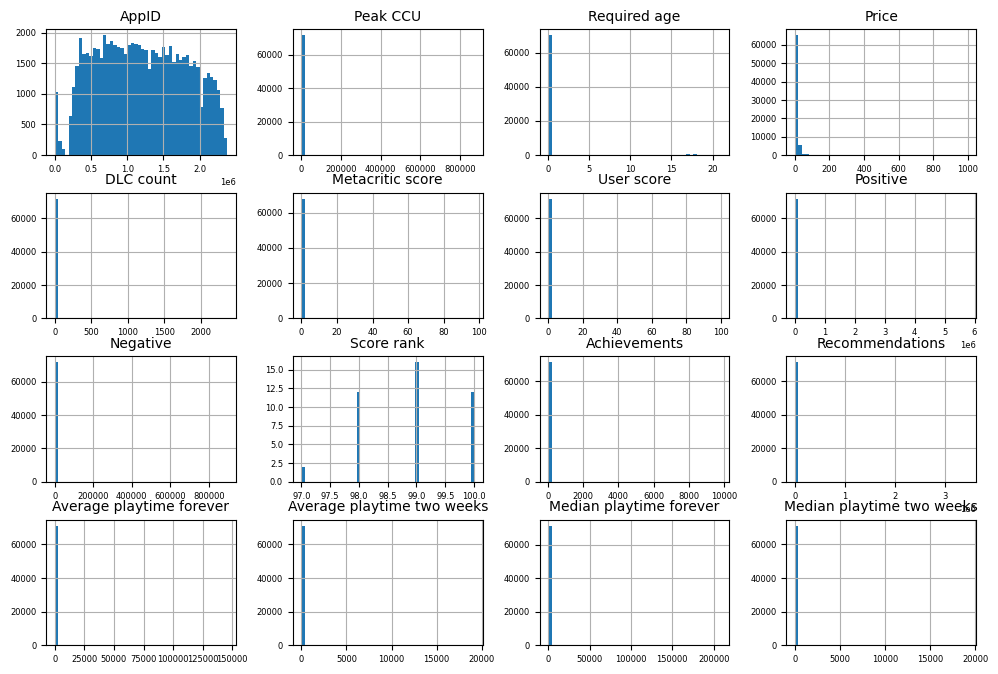

In [7]:
import matplotlib.pyplot as plt

# to define the default font sizes
plt.rc('font', size=10)
plt.rc('axes', labelsize=10, titlesize=10)
plt.rc('legend', fontsize=10)
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=6)

games.hist(bins=50, figsize=(12, 8))
plt.show()

## Create Test and Train Sets

In [8]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
train_set, test_set = shuffle_and_split_data(games, 0.2)
len(train_set)

57373

In [10]:
len(test_set)

14343

In [11]:
np.random.seed(42)

In [12]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
games_with_id = games.reset_index()  # adds an `index` column
train_set, test_set = split_data_with_id_hash(games_with_id, 0.2, "index")

In [14]:
# Save the test set to a CSV file with the name "games_test.csv"
test_set.to_csv("games_test.csv", index=False)

In [15]:
from sklearn.model_selection import train_test_split


# Splitting the dataset into training and test sets
train_set, test_set = train_test_split(games, test_size=0.2, random_state=42)

# save these sets to CSV files
train_set.to_csv("games_train.csv", index=False)
test_set.to_csv("games_test.csv", index=False)


# Exploratory Data Analysis

<Axes: >

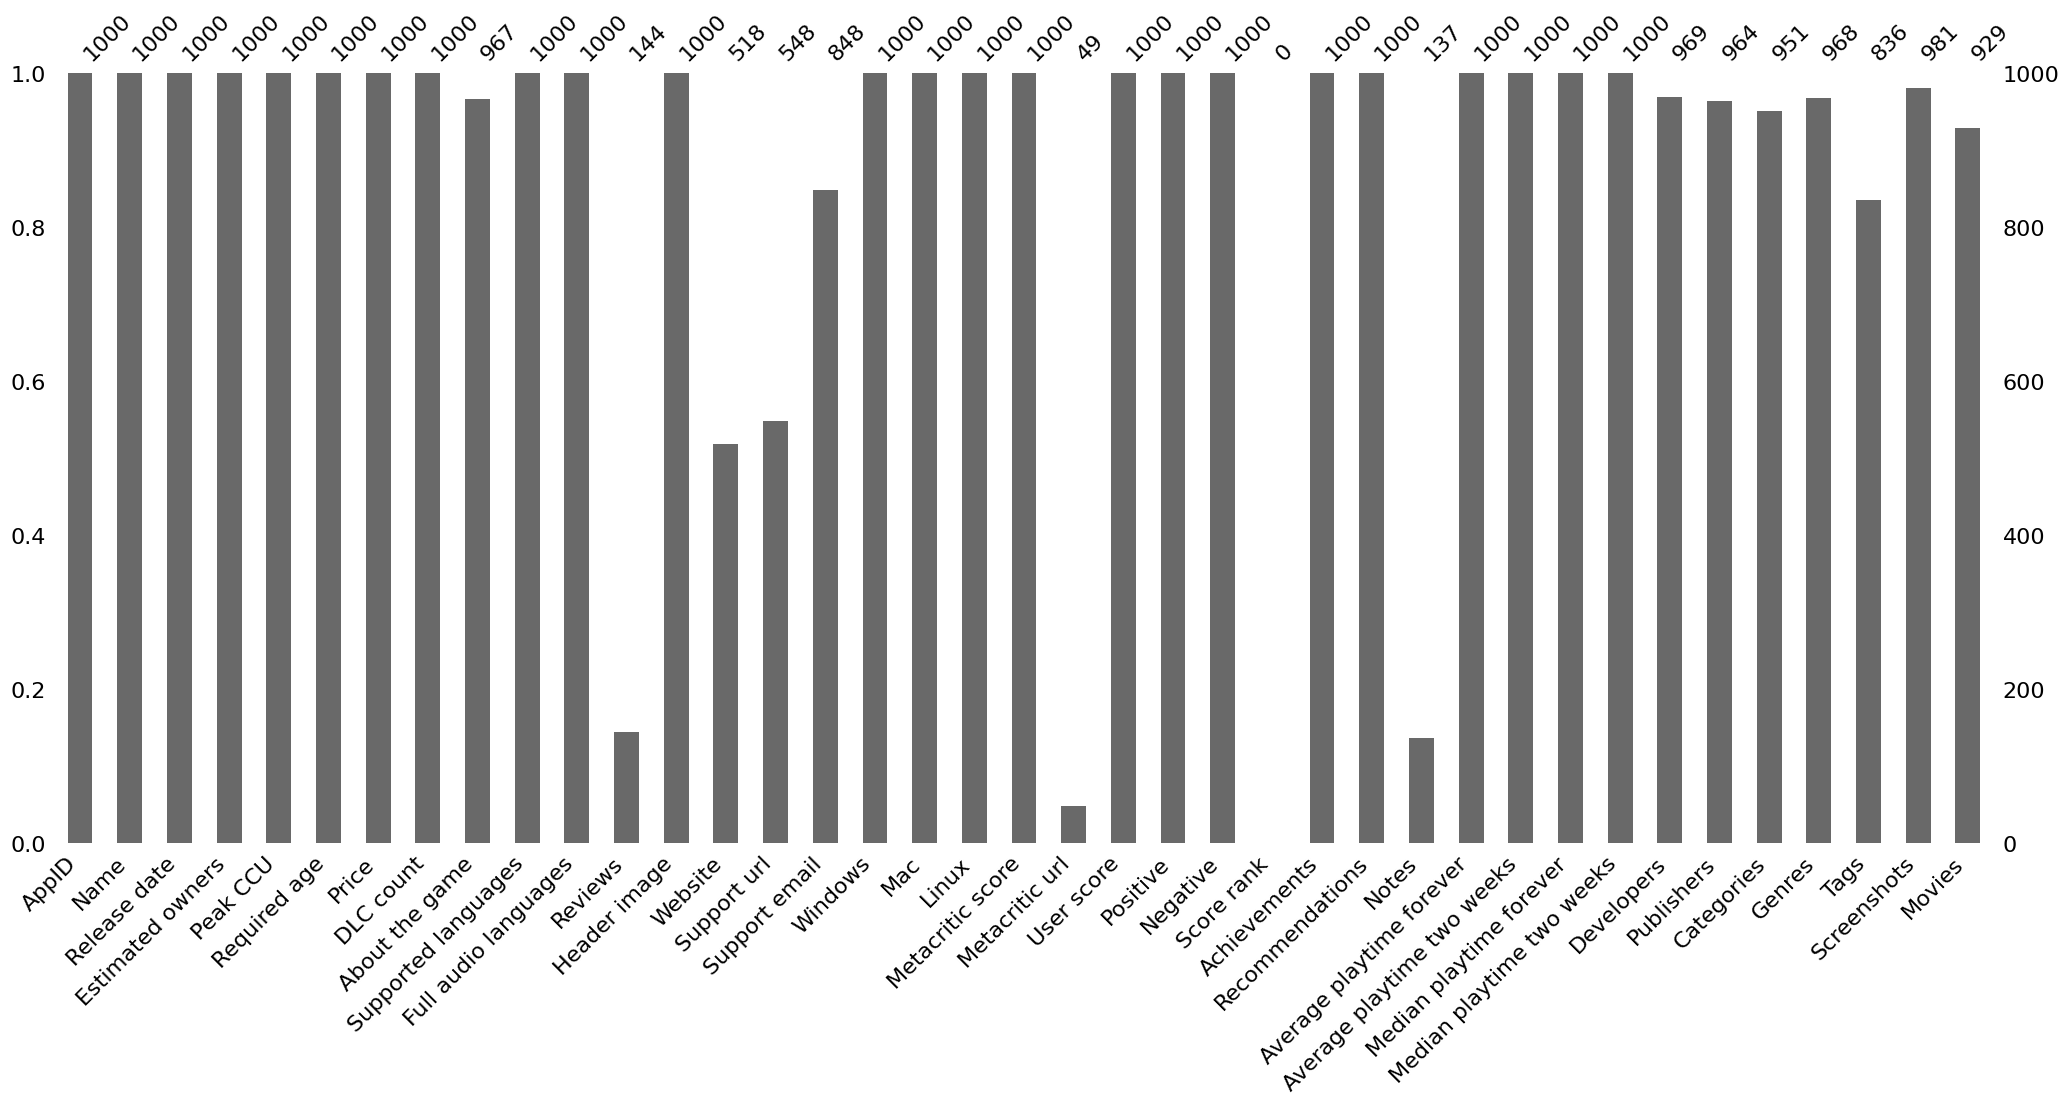

In [16]:
# missing values 

import missingno as msno
import matplotlib.pyplot as plt

msno.bar(games.sample(1000))

<Axes: >

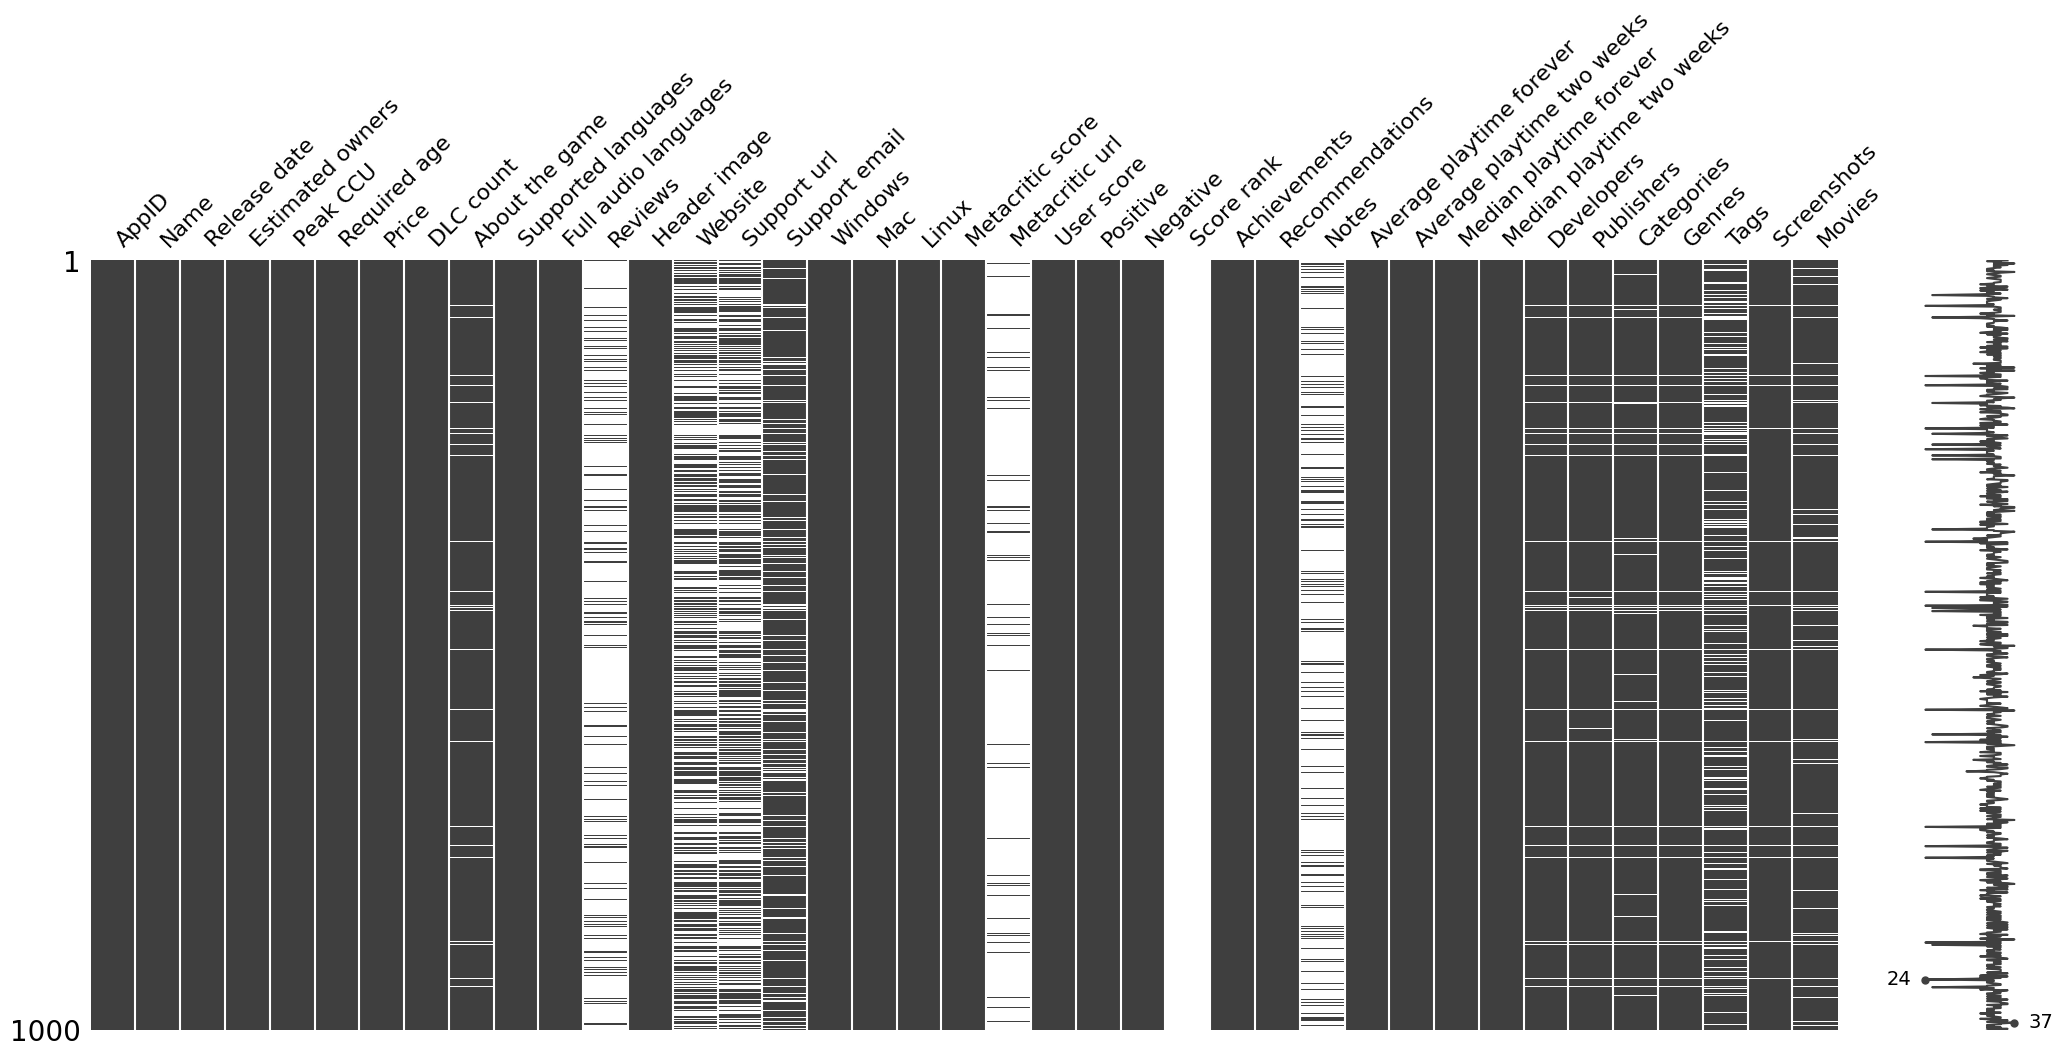

In [17]:
msno.matrix(games.sample(1000))

                           Data Type  Missing Values (%)
AppID                          int64            0.000000
Name                          object            0.001394
Release date                  object            0.000000
Estimated owners              object            0.000000
Peak CCU                       int64            0.000000
Required age                   int64            0.000000
Price                        float64            0.000000
DLC count                      int64            0.000000
About the game                object            3.396732
Supported languages           object            0.000000
Full audio languages          object            0.000000
Reviews                       object           87.217636
Header image                  object            0.000000
Website                       object           51.094595
Support url                   object           49.453400
Support email                 object           15.505605
Windows                        

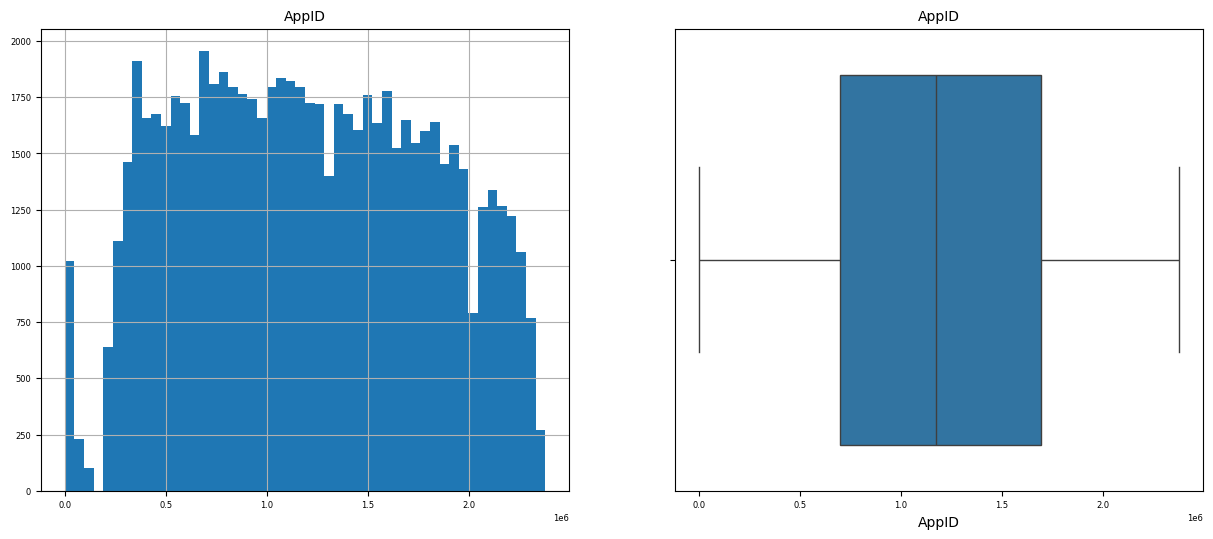

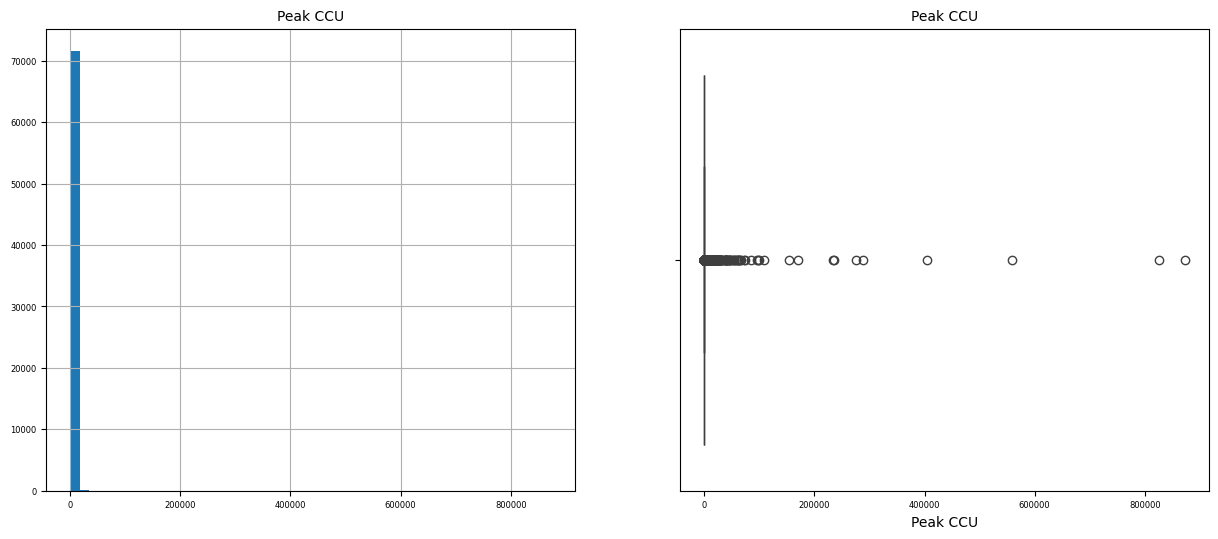

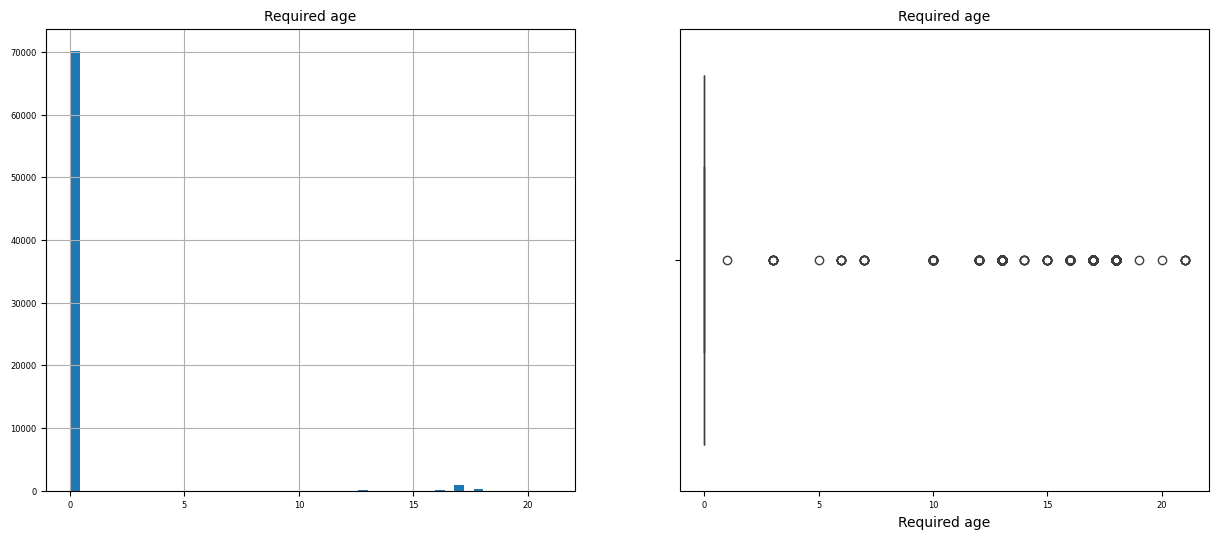

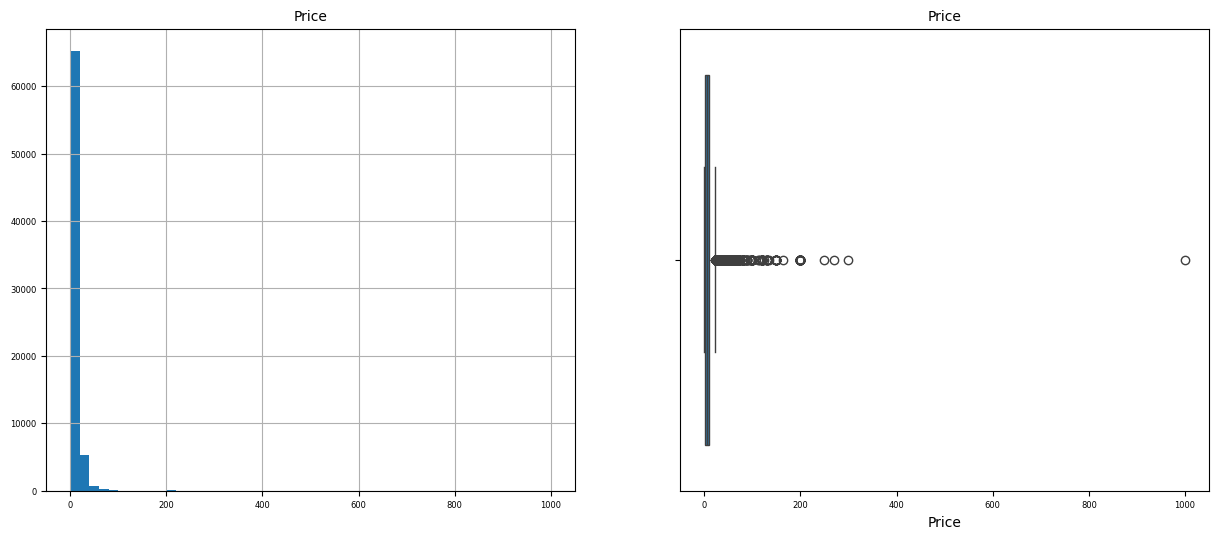

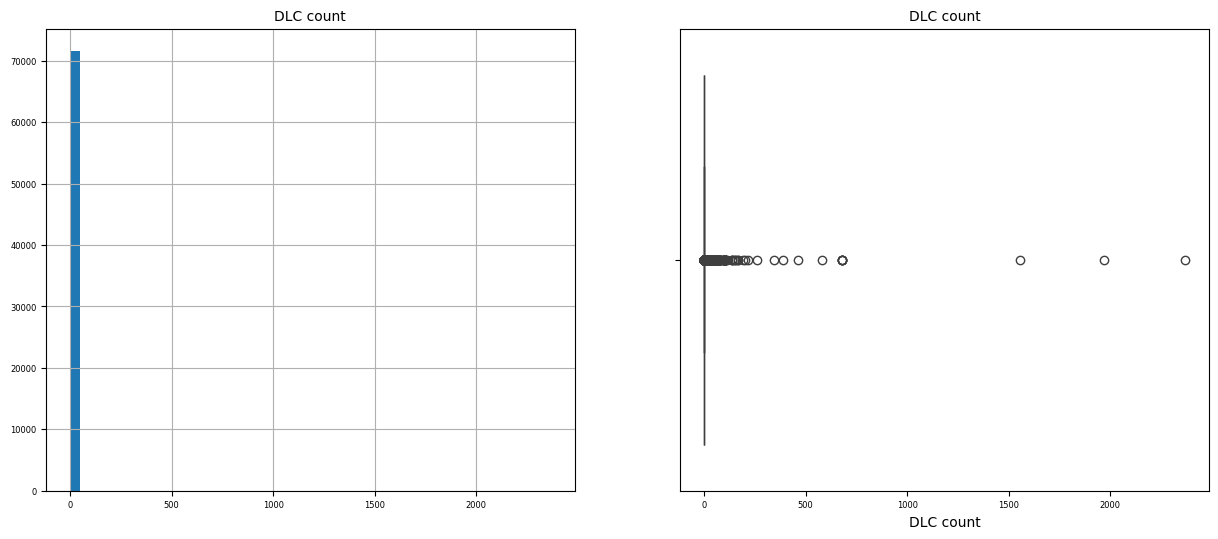

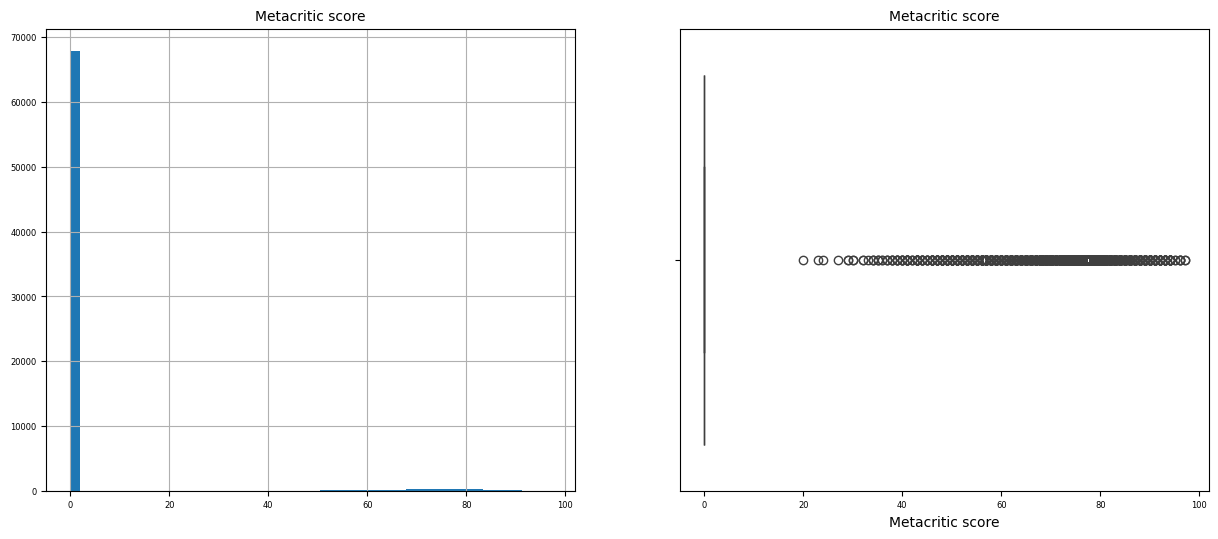

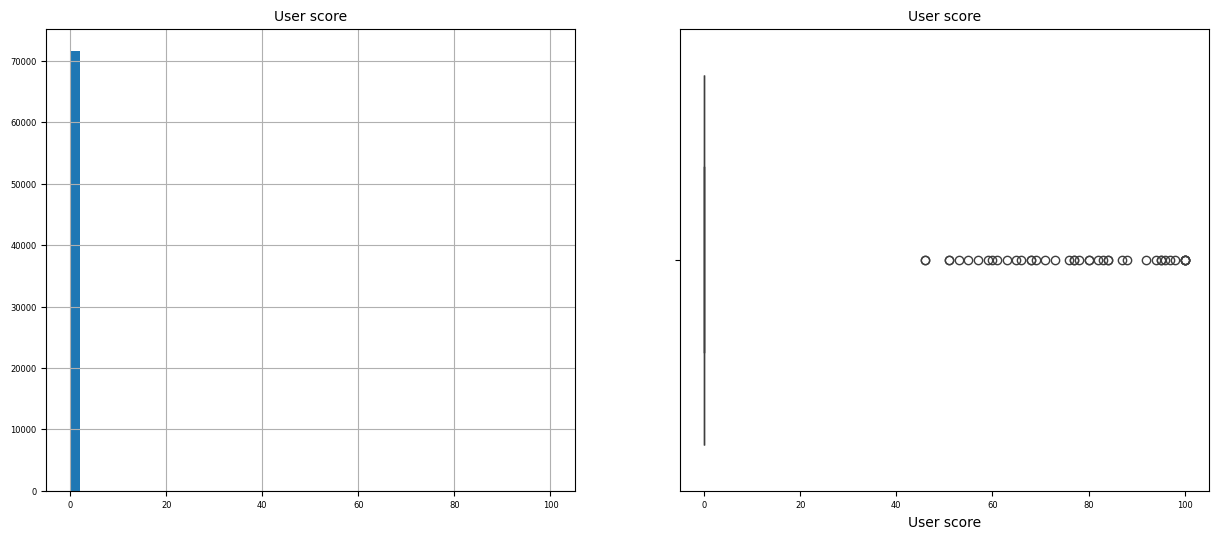

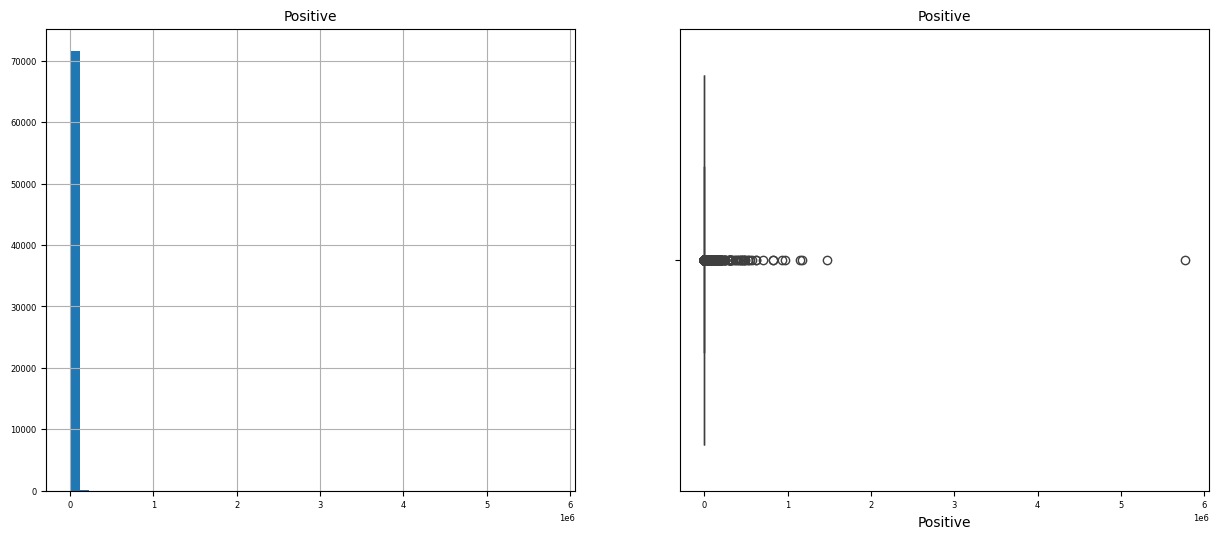

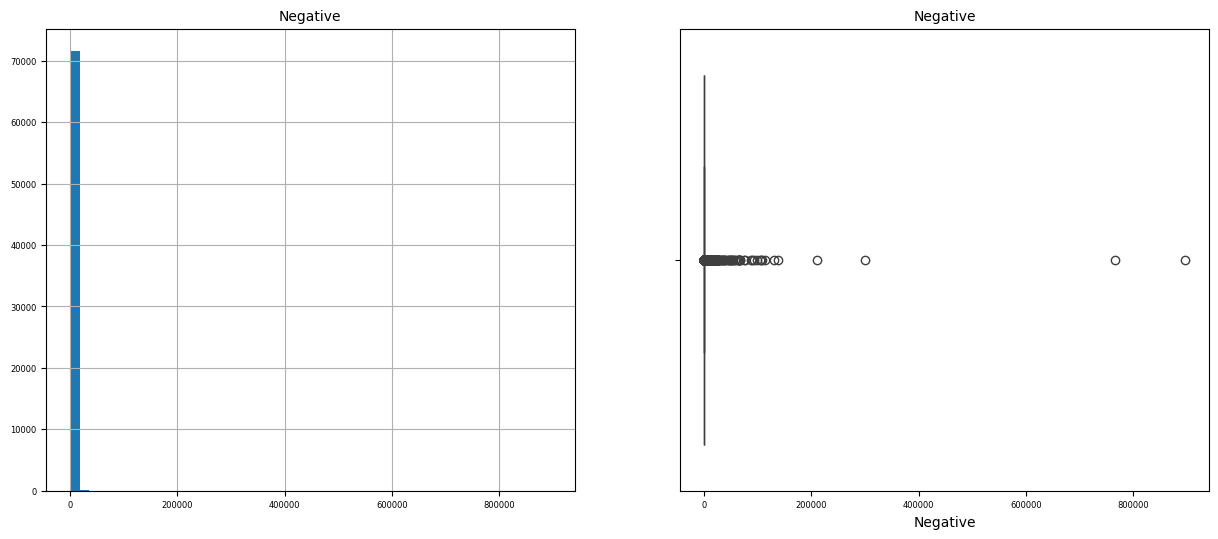

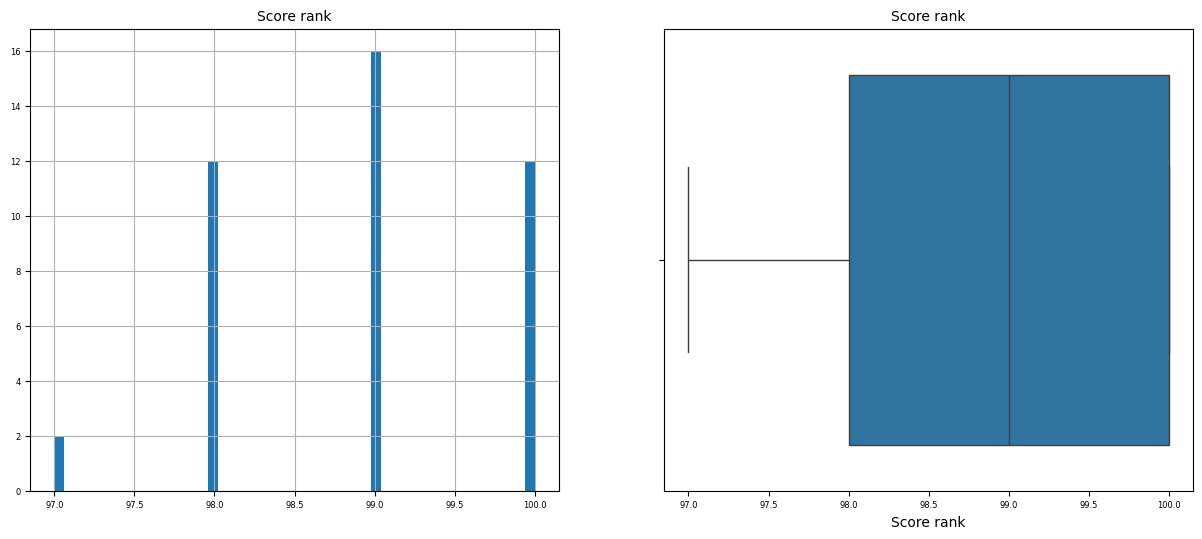

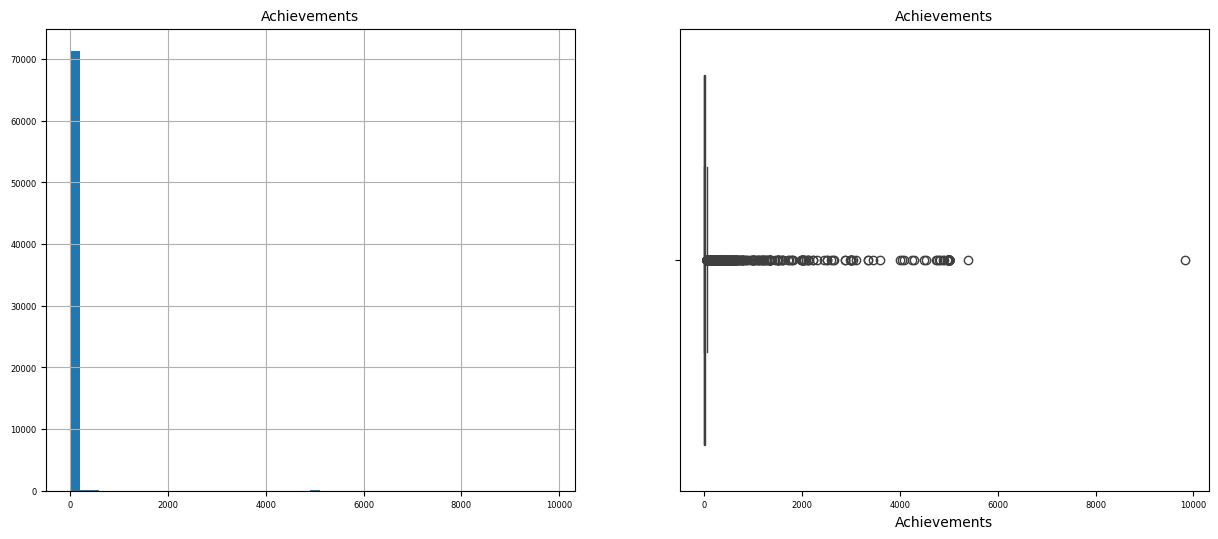

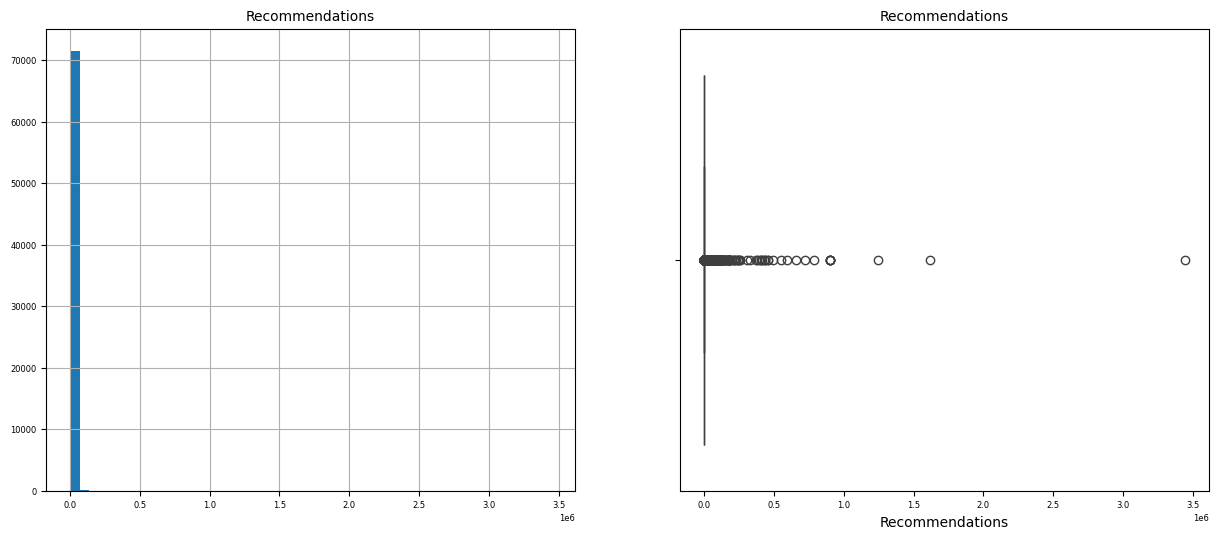

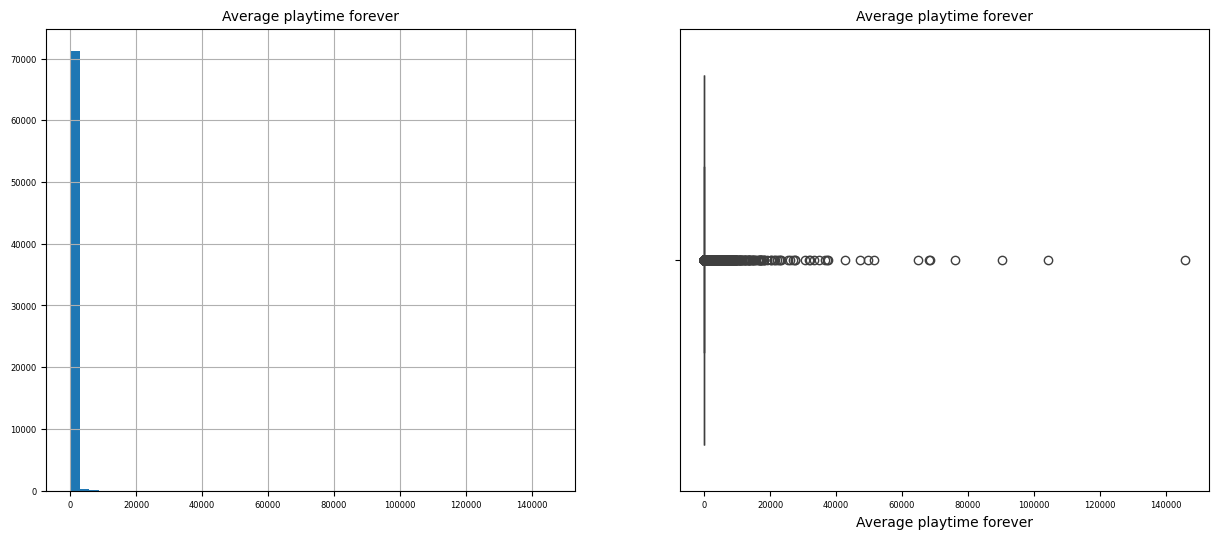

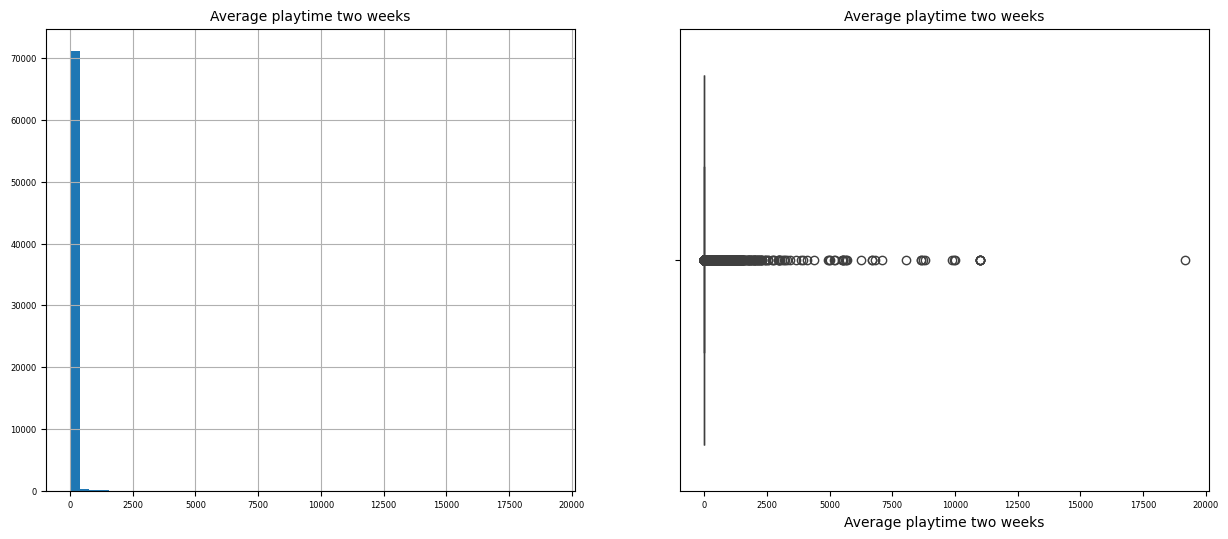

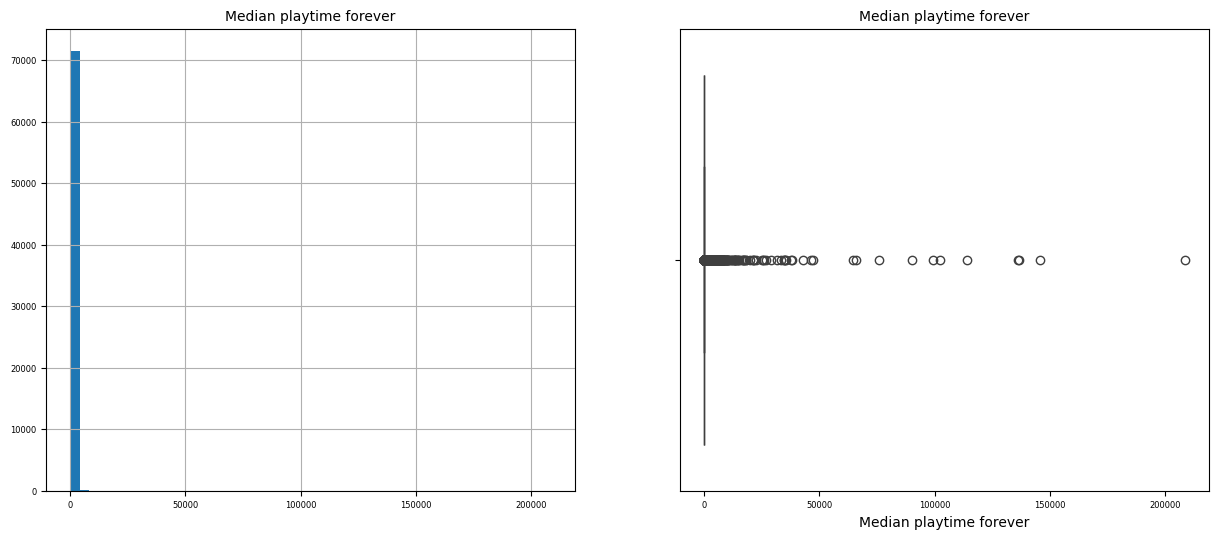

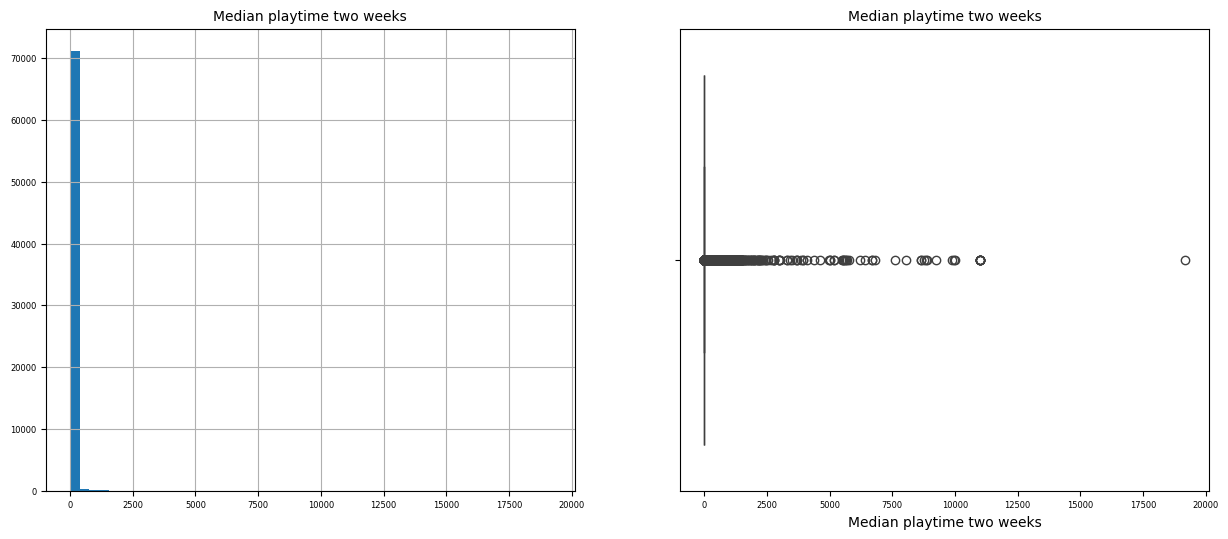

In [18]:
import seaborn as sns

# Basic data types
data_types = games.dtypes

# Percentage of missing values
missing_values = games.isnull().mean() * 100

# Initial analysis results
analysis = pd.DataFrame({'Data Type': data_types, 'Missing Values (%)': missing_values})
print(analysis)

# Visualizing distributions and potential outliers/noise for numeric columns
for column in games.select_dtypes(include=['float64', 'int64']):
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    games[column].hist(bins=50)
    plt.title(column)

    plt.subplot(1, 2, 2)
    sns.boxplot(x=games[column])
    plt.title(column)

    plt.show()

In [19]:
# Basic data types
data_types = games.dtypes
data_types
games.columns

Index(['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU',
       'Required age', 'Price', 'DLC count', 'About the game',
       'Supported languages', 'Full audio languages', 'Reviews',
       'Header image', 'Website', 'Support url', 'Support email', 'Windows',
       'Mac', 'Linux', 'Metacritic score', 'Metacritic url', 'User score',
       'Positive', 'Negative', 'Score rank', 'Achievements', 'Recommendations',
       'Notes', 'Average playtime forever', 'Average playtime two weeks',
       'Median playtime forever', 'Median playtime two weeks', 'Developers',
       'Publishers', 'Categories', 'Genres', 'Tags', 'Screenshots', 'Movies'],
      dtype='object')

## Handling Missing Values

In [20]:
# Dropping specified columns with more than 85% missing values
columns_to_drop = ['Reviews', 'Score rank', 'Metacritic url', 'Notes']
for column in columns_to_drop:
    if games[column].isnull().mean() > 0.85:
        games.drop(column, axis=1, inplace=True)

# Saving the modified dataset (optional)
#games.to_csv("/Users/sheidamajidi/Desktop/Winter2024/COURSES/INSY695/Individual Assignments/ML1/SteamGames/games_cleaned.csv", index=False) 

print(games.head())

     AppID                   Name  Release date Estimated owners  Peak CCU  \
0    20200       Galactic Bowling  Oct 21, 2008        0 - 20000         0   
1   655370           Train Bandit  Oct 12, 2017        0 - 20000         0   
2  1732930           Jolt Project  Nov 17, 2021        0 - 20000         0   
3  1355720               Henosis™  Jul 23, 2020        0 - 20000         0   
4  1139950  Two Weeks in Painland   Feb 3, 2020        0 - 20000         0   

   Required age  Price  DLC count  \
0             0  19.99          0   
1             0   0.99          0   
2             0   4.99          0   
3             0   5.99          0   
4             0   0.00          0   

                                      About the game  \
0  Galactic Bowling is an exaggerated and stylize...   
1  THE LAW!! Looks to be a showdown atop a train....   
2  Jolt Project: The army now has a new robotics ...   
3  HENOSIS™ is a mysterious 2D Platform Puzzler w...   
4  ABOUT THE GAME Play as a 

In [21]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Select only numeric columns for imputation
numeric_cols = games.select_dtypes(include=[np.number])

iterative_imputer = IterativeImputer()
imputed_data = iterative_imputer.fit_transform(numeric_cols)

# Creating a DataFrame with the imputed data
imputed_df = pd.DataFrame(imputed_data, columns=numeric_cols.columns)

# Merging imputed numeric data back with non-numeric data
games[numeric_cols.columns] = imputed_df


In [22]:
# Select only numeric columns
numeric_columns = games.select_dtypes(include=[np.number]).columns

# Print the list of numeric columns
print("Numeric columns in the dataset:")
print(numeric_columns.tolist())

Numeric columns in the dataset:
['AppID', 'Peak CCU', 'Required age', 'Price', 'DLC count', 'Metacritic score', 'User score', 'Positive', 'Negative', 'Achievements', 'Recommendations', 'Average playtime forever', 'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks']


## Handling Categorical Columns

In [23]:
# Process the 'Suppported languages' column

# Prepare numeric features (X) and target (y)
# Include only numeric columns and 'Supported languages' as a categorical column
numeric_cols = ['Required age', 'Price', 'DLC count', 
                 'Metacritic score', 'User score', 'Positive', 'Negative', 'Achievements', 
                 'Recommendations', 'Average playtime forever', 'Average playtime two weeks', 
                 'Median playtime forever', 'Median playtime two weeks']

X = games[numeric_cols + ['Supported languages']]
y = games['Peak CCU']

from catboost import CatBoostRegressor

model = CatBoostRegressor(cat_features=['Supported languages'], random_state=42)

# Fit the model
model.fit(X, y)


Learning rate set to 0.080421
0:	learn: 5731.8134970	total: 72.1ms	remaining: 1m 12s
1:	learn: 5624.9583838	total: 103ms	remaining: 51.3s
2:	learn: 5539.9867463	total: 118ms	remaining: 39.2s
3:	learn: 5418.0358263	total: 127ms	remaining: 31.7s
4:	learn: 5300.9617579	total: 134ms	remaining: 26.7s
5:	learn: 5247.5105625	total: 140ms	remaining: 23.2s
6:	learn: 5196.4251373	total: 145ms	remaining: 20.6s
7:	learn: 5146.7809174	total: 150ms	remaining: 18.6s
8:	learn: 5098.2620089	total: 157ms	remaining: 17.3s
9:	learn: 5051.6597366	total: 163ms	remaining: 16.1s
10:	learn: 4946.5697611	total: 168ms	remaining: 15.1s
11:	learn: 4903.3706849	total: 173ms	remaining: 14.2s
12:	learn: 4861.8649109	total: 178ms	remaining: 13.5s
13:	learn: 4821.6106216	total: 182ms	remaining: 12.8s
14:	learn: 4782.6437441	total: 189ms	remaining: 12.4s
15:	learn: 4745.1269425	total: 195ms	remaining: 12s
16:	learn: 4708.9366963	total: 200ms	remaining: 11.6s
17:	learn: 4674.0279912	total: 206ms	remaining: 11.3s
18:	lear

In [24]:
# Process the 'Full audio languages' column

# Function to convert list of languages into a single string
def concat_languages(lang_list):
    return ', '.join(lang_list) if isinstance(lang_list, list) else lang_list

# Apply the function to the 'Full audio languages' column
games['Full audio languages'] = games['Full audio languages'].apply(concat_languages)

# Prepare your features (X) and target (y)
numeric_cols = ['Required age', 'Price', 'DLC count', 
                'Metacritic score', 'User score', 'Positive', 'Negative', 
                'Achievements', 'Recommendations', 'Average playtime forever', 
                'Average playtime two weeks', 'Median playtime forever', 
                'Median playtime two weeks']

X = games[numeric_cols + ['Full audio languages']]
y = games['Peak CCU']

# Instantiate a CatBoost model
model = CatBoostRegressor(cat_features=['Full audio languages'], random_state=42)

# Fit the model
model.fit(X, y)


Learning rate set to 0.080421
0:	learn: 5731.8134970	total: 6.81ms	remaining: 6.8s
1:	learn: 5624.9583838	total: 14ms	remaining: 6.98s
2:	learn: 5539.9867463	total: 19.2ms	remaining: 6.39s
3:	learn: 5418.0358263	total: 25.9ms	remaining: 6.46s
4:	learn: 5300.9617579	total: 30.8ms	remaining: 6.14s
5:	learn: 5247.5105625	total: 35.6ms	remaining: 5.89s
6:	learn: 5196.4251373	total: 40.1ms	remaining: 5.68s
7:	learn: 5146.7809174	total: 44.3ms	remaining: 5.49s
8:	learn: 5098.2620089	total: 49.9ms	remaining: 5.49s
9:	learn: 5051.6597366	total: 55ms	remaining: 5.44s
10:	learn: 4946.5697611	total: 59.8ms	remaining: 5.38s
11:	learn: 4903.3706849	total: 63.9ms	remaining: 5.26s
12:	learn: 4861.8649109	total: 68.8ms	remaining: 5.22s
13:	learn: 4821.6106216	total: 72.8ms	remaining: 5.13s
14:	learn: 4782.6437441	total: 78.1ms	remaining: 5.13s
15:	learn: 4745.1269425	total: 83.1ms	remaining: 5.11s
16:	learn: 4708.9366963	total: 87.7ms	remaining: 5.07s
17:	learn: 4674.0279912	total: 92.7ms	remaining: 5

In [25]:
# Process the 'Genres', 'Categories', and 'Tags' columns

# Function to transform comma-separated strings into single strings
def transform_column(col):
    return col.apply(lambda x: x if isinstance(x, str) else '')

# Apply the function to the 'Genres', 'Categories', and 'Tags' columns
games['Genres'] = transform_column(games['Genres'])
games['Categories'] = transform_column(games['Categories'])
games['Tags'] = transform_column(games['Tags'])

# Prepare features (X) and target (y)
numeric_cols = ['Required age', 'Price', 'DLC count', 
                'Metacritic score', 'User score', 'Positive', 'Negative', 
                'Achievements', 'Recommendations', 'Average playtime forever', 
                'Average playtime two weeks', 'Median playtime forever', 
                'Median playtime two weeks']

categorical_cols = ['Genres', 'Categories', 'Tags', 'Full audio languages']

X = games[numeric_cols + categorical_cols]
y = games['Peak CCU']

# Instantiate a CatBoost model
model = CatBoostRegressor(cat_features=categorical_cols, random_state=42)

# Fit the model
model.fit(X, y)


Learning rate set to 0.080421
0:	learn: 5686.5455053	total: 11.5ms	remaining: 11.5s
1:	learn: 5577.5465623	total: 22.6ms	remaining: 11.3s
2:	learn: 5517.3043343	total: 32.6ms	remaining: 10.8s
3:	learn: 5459.3824489	total: 42.1ms	remaining: 10.5s
4:	learn: 5377.5345604	total: 49.3ms	remaining: 9.82s
5:	learn: 5317.9421838	total: 60.5ms	remaining: 10s
6:	learn: 5266.7216925	total: 70.6ms	remaining: 10s
7:	learn: 5217.3090399	total: 78ms	remaining: 9.67s
8:	learn: 5169.6983236	total: 86.5ms	remaining: 9.52s
9:	learn: 5123.5804208	total: 95.7ms	remaining: 9.47s
10:	learn: 5078.9948820	total: 106ms	remaining: 9.57s
11:	learn: 5030.7479132	total: 117ms	remaining: 9.66s
12:	learn: 4988.6632463	total: 127ms	remaining: 9.6s
13:	learn: 4948.3148090	total: 135ms	remaining: 9.51s
14:	learn: 4911.0359051	total: 141ms	remaining: 9.26s
15:	learn: 4873.8370548	total: 149ms	remaining: 9.19s
16:	learn: 4838.3357817	total: 156ms	remaining: 8.99s
17:	learn: 4804.1625988	total: 164ms	remaining: 8.96s
18:	l

In [26]:
pd.set_option('display.max_columns', None)

print(games.columns.tolist())

# Reset pandas display options to default
#pd.reset_option('display.max_columns')

['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU', 'Required age', 'Price', 'DLC count', 'About the game', 'Supported languages', 'Full audio languages', 'Header image', 'Website', 'Support url', 'Support email', 'Windows', 'Mac', 'Linux', 'Metacritic score', 'User score', 'Positive', 'Negative', 'Achievements', 'Recommendations', 'Average playtime forever', 'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks', 'Developers', 'Publishers', 'Categories', 'Genres', 'Tags', 'Screenshots', 'Movies']


## Looking for Correlations

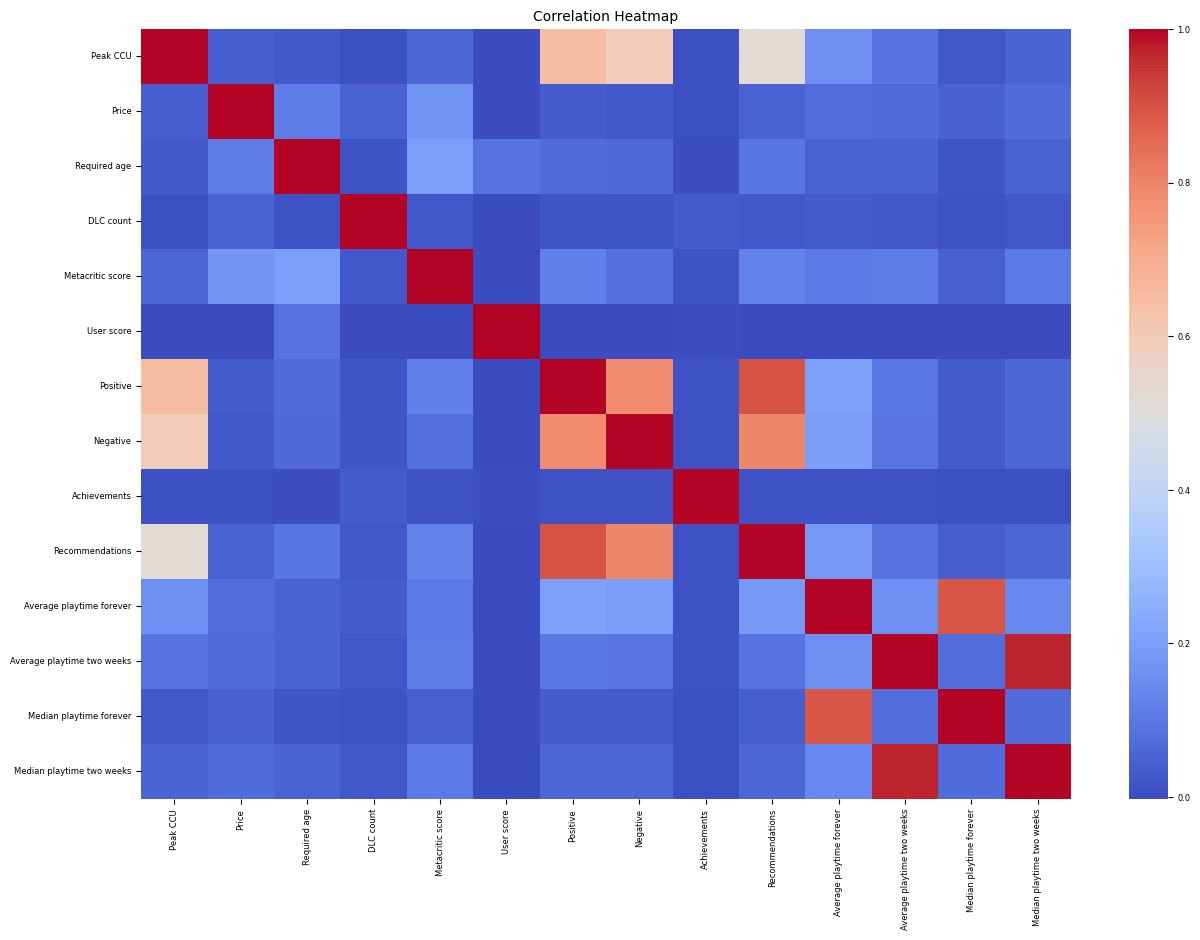

In [27]:
# Visualize the correlation between numeric columns
import seaborn as sns

games['Peak CCU'] = pd.to_numeric(games['Peak CCU'], errors='coerce')

# Select numeric columns and a few key encoded categorical columns for correlation
selected_columns = ['Peak CCU', 'Price', 'Required age', 'DLC count', 'Metacritic score', 
                    'User score', 'Positive', 'Negative', 'Achievements', 'Recommendations','Average playtime forever',
                    'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks']


correlations = games[selected_columns].corr()

# Plot correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlations, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [28]:
corr_matrix = games.corr(numeric_only=True)

In [29]:
corr_matrix['Price'].sort_values(ascending=False)

Price                         1.000000
Metacritic score              0.171242
Required age                  0.111189
Average playtime forever      0.074795
Average playtime two weeks    0.071032
Median playtime two weeks     0.069886
Recommendations               0.050520
DLC count                     0.050423
Median playtime forever       0.048141
Peak CCU                      0.039669
Positive                      0.034613
Negative                      0.028402
Mac                           0.024184
Linux                         0.012521
Achievements                  0.006157
User score                   -0.000177
Windows                      -0.023882
AppID                        -0.086032
Name: Price, dtype: float64

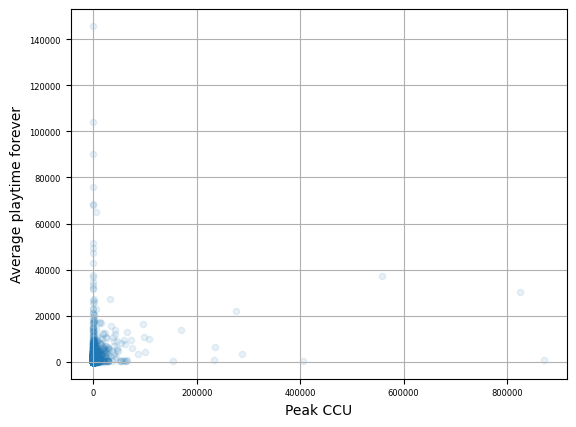

In [30]:
games.plot(kind="scatter", x='Peak CCU', y='Average playtime forever',
             alpha=0.1, grid=True)
plt.show()

# Prepare the Data for Machine Learning Algorithms

In [31]:
# Train set

games_train = pd.read_csv("games_train.csv")

# Define the transformation functions
def safe_eval(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

def concat_languages(lang_list):
    return ', '.join(lang_list) if isinstance(lang_list, list) else lang_list

def transform_column(col):
    return col.apply(lambda x: x if isinstance(x, str) else '')

# Apply transformations to games_train
games_train['Supported languages'] = games_train['Supported languages'].apply(safe_eval)
games_train['Full audio languages'] = games_train['Full audio languages'].apply(concat_languages)
games_train['Genres'] = transform_column(games_train['Genres'])
games_train['Categories'] = transform_column(games_train['Categories'])
games_train['Tags'] = transform_column(games_train['Tags'])

# Impute missing numeric values
numeric_cols = games_train.select_dtypes(include=[np.number])
iterative_imputer = IterativeImputer()
imputed_data = iterative_imputer.fit_transform(numeric_cols)
imputed_df = pd.DataFrame(imputed_data, columns=numeric_cols.columns)
games_train[numeric_cols.columns] = imputed_df

# Drop columns with more than 85% missing values
columns_to_drop = ['Reviews', 'Score rank', 'Metacritic url', 'Notes']
for column in columns_to_drop:
    if games_train[column].isnull().mean() > 0.85:
        games_train.drop(column, axis=1, inplace=True)

# Prepare features (X) and target (y) for CatBoost model
numeric_cols = ['Required age', 'Price', 'DLC count', 
                'Metacritic score', 'User score', 'Positive', 'Negative', 
                'Achievements', 'Recommendations', 'Average playtime forever', 
                'Average playtime two weeks', 'Median playtime forever', 
                'Median playtime two weeks']
categorical_cols = ['Genres', 'Categories', 'Tags', 'Full audio languages']
X_train = games_train[numeric_cols + categorical_cols]
y_train = games_train['Peak CCU']

# Initialize and fit the CatBoost model
model = CatBoostRegressor(cat_features=categorical_cols, random_state=42)
model.fit(X_train, y_train)


Learning rate set to 0.077634
0:	learn: 6183.4581113	total: 26.1ms	remaining: 26.1s
1:	learn: 6121.8629305	total: 35.4ms	remaining: 17.7s
2:	learn: 6033.5972349	total: 43.5ms	remaining: 14.4s
3:	learn: 5976.8180101	total: 53.4ms	remaining: 13.3s
4:	learn: 5917.9690207	total: 62.3ms	remaining: 12.4s
5:	learn: 5860.8652622	total: 71ms	remaining: 11.8s
6:	learn: 5806.0686621	total: 77.8ms	remaining: 11s
7:	learn: 5755.6262836	total: 85.6ms	remaining: 10.6s
8:	learn: 5703.2165829	total: 92.7ms	remaining: 10.2s
9:	learn: 5652.5737334	total: 102ms	remaining: 10.1s
10:	learn: 5604.3510077	total: 110ms	remaining: 9.89s
11:	learn: 5560.0093667	total: 117ms	remaining: 9.64s
12:	learn: 5514.6958513	total: 124ms	remaining: 9.44s
13:	learn: 5473.3920441	total: 132ms	remaining: 9.32s
14:	learn: 5433.3713061	total: 140ms	remaining: 9.19s
15:	learn: 5394.6871922	total: 148ms	remaining: 9.09s
16:	learn: 5357.2612364	total: 155ms	remaining: 8.94s
17:	learn: 5318.3975166	total: 162ms	remaining: 8.87s
18:

In [32]:
#sns.pairplot(games_train[['Peak CCU', 'Required age', 'Price',
#'Average playtime forever', 'Average playtime two weeks',
#       'Median playtime forever', 'Median playtime two weeks']])
#plt.show()

## Data Cleaning

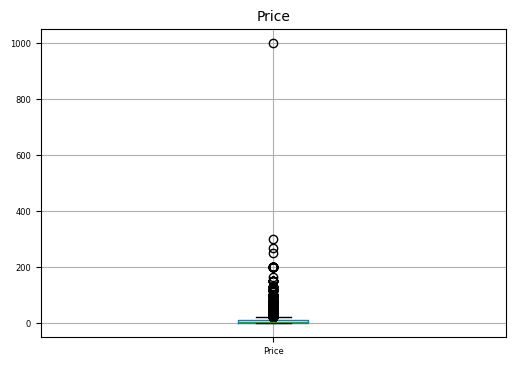

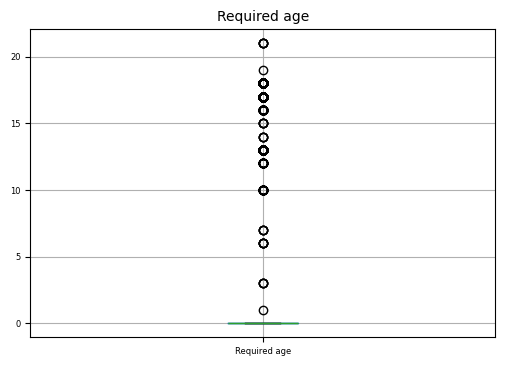

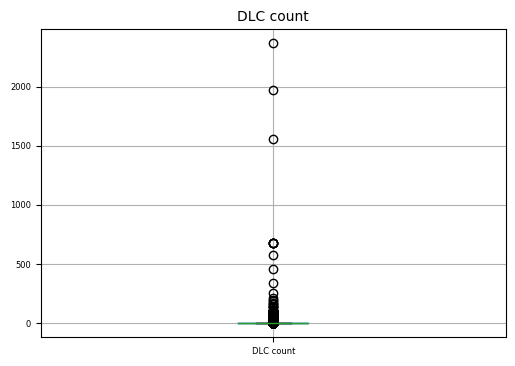

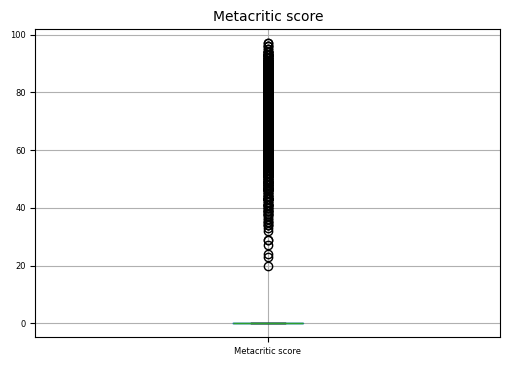

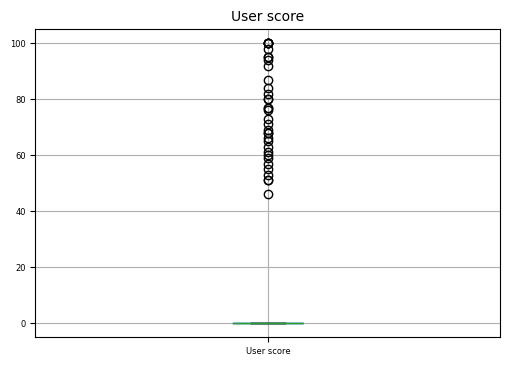

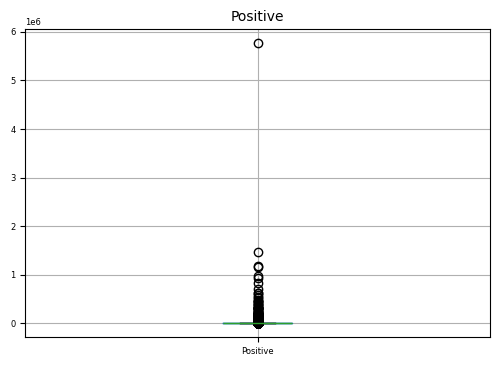

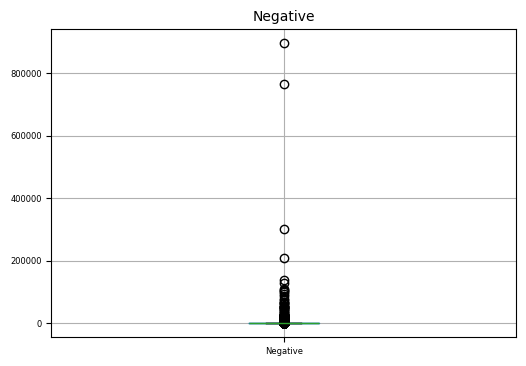

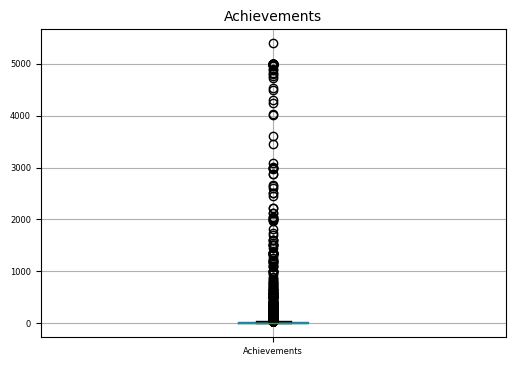

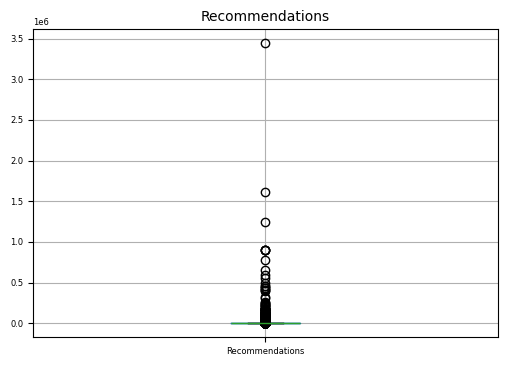

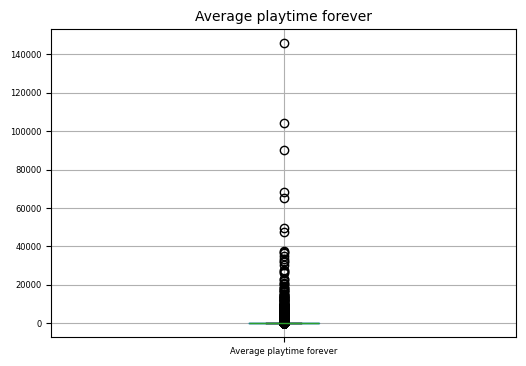

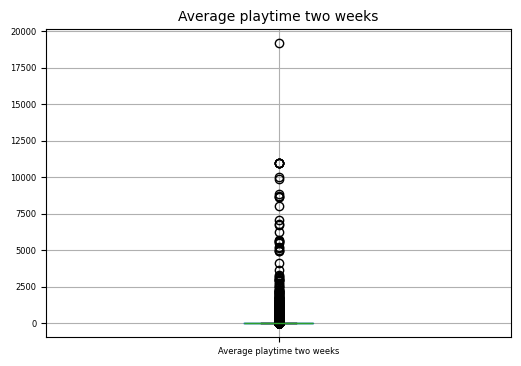

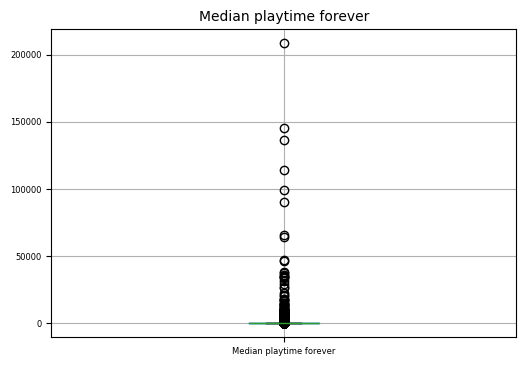

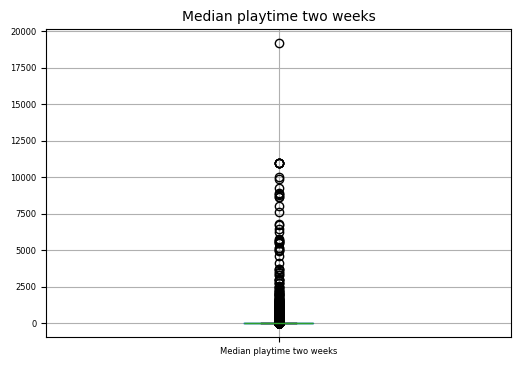

In [33]:
# Identify outliers in numeric columns using boxplots

# List of numeric columns to check for outliers
columns_to_check = ['Price', 'Required age', 'DLC count', 'Metacritic score', 
                    'User score', 'Positive', 'Negative', 'Achievements', 
                    'Recommendations', 'Average playtime forever',
                    'Average playtime two weeks', 'Median playtime forever', 
                    'Median playtime two weeks']

# Plotting boxplots for each column
for col in columns_to_check:
    plt.figure(figsize=(6, 4))
    games_train.boxplot(column=col)
    plt.title(col)
    plt.show()

In [34]:
# Identify and remove outliers using Isolation Forest

from sklearn.ensemble import IsolationForest

# Selecting relevant numeric features
feature_columns = ['Price', 'Required age', 'DLC count', 'Metacritic score',
                   'User score', 'Positive', 'Negative', 'Achievements',
                   'Recommendations', 'Average playtime forever',
                   'Average playtime two weeks', 'Median playtime forever',
                   'Median playtime two weeks']
X = games_train[feature_columns]

# Initialize and fit the Isolation Forest model
isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

# Filter out the outliers (outlier_pred == -1 indicates an outlier)
games_train_filtered = games_train[outlier_pred != -1]

# Optionally, save the filtered dataset to a new CSV file
games_train_filtered.to_csv("games_without_outliers.csv", index=False)


In [35]:
outlier_pred

array([1, 1, 1, ..., 1, 1, 1])

In [36]:
# Outlier detection results

# Count the number of outliers
num_outliers = np.sum(outlier_pred == -1)
num_normal = np.sum(outlier_pred == 1)

print(f"Number of Outliers: {num_outliers}")
print(f"Number of Normal Observations: {num_normal}")

# Optionally, examine the outliers
outliers = games_train[outlier_pred == -1]
print(outliers[feature_columns])


Number of Outliers: 3591
Number of Normal Observations: 53781
       Price  Required age  DLC count  Metacritic score  User score  Positive  \
18      9.99           0.0        0.0              64.0         0.0     119.0   
20     39.99           0.0       36.0               0.0         0.0    1027.0   
21     14.99           0.0        7.0              72.0         0.0     585.0   
24      4.99           0.0        0.0              83.0         0.0    2246.0   
48     14.99           0.0        3.0              58.0         0.0    1566.0   
...      ...           ...        ...               ...         ...       ...   
57198  39.99           0.0        1.0               0.0         0.0     763.0   
57201  12.99           0.0        1.0              77.0         0.0     208.0   
57248  24.99           0.0        0.0              60.0         0.0    1008.0   
57285  29.99           0.0        1.0               0.0         0.0   14035.0   
57352  14.99           0.0        0.0          

In [37]:
# Filter out the outliers (outlier_pred == -1 indicates an outlier)
games_train_filtered = games_train[outlier_pred != -1]

# Save the filtered dataset to a new CSV file
#games_filtered.to_csv("games_without_outliers.csv", index=False)

print(f"Original Dataset Size: {len(games_train)}")
print(f"Filtered Dataset Size: {len(games_train_filtered)}")



Original Dataset Size: 57372
Filtered Dataset Size: 53781


In [38]:
## Drop unnecessary columns (not significant for predicting the target variable of Peak CCU)

games_train_filtered = games_train_filtered.drop(columns=['AppID', 'Name', 'Estimated owners', 'Support url', 'Movies', 
                                              'Header image', 'Website', 'Support email', 'Screenshots',
                                              'Metacritic score', 'User score', 'Achievements', 'Recommendations'])

# Save the filtered dataset to a new CSV file
games_train_filtered.to_csv("games_train_filtered.csv", index=False)


## Handling Text ('About the game')

In [39]:
games_train_filtered

,Release date,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,Full audio languages,Windows,Mac,Linux,Positive,Negative,Score rank,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags
0,"Oct 3, 2022",0.0,0.0,2.99,0.0,"The car has wheels, the plane has wings, and t...",[English],[],True,False,False,0.0,0.0,95.855654,0.0,0.0,0.0,0.0,"Atomic Fabrik,Cristian Manolachi","Atomic Fabrik,Cristian Manolachi","Single-player,Partial Controller Support","Casual,Indie,Simulation,Sports",
1,"Jan 24, 2018",0.0,0.0,0.99,0.0,Jumbo is a crazy platformer where you will pla...,[English],[],True,False,False,0.0,2.0,95.567833,0.0,0.0,0.0,0.0,Polina Medyanik,Polina Medyanik,Single-player,"Casual,Indie","Indie,Casual"
2,"Feb 10, 2023",0.0,0.0,0.00,0.0,Maria's life is falling apart: she's lost her ...,[English],[],True,False,True,0.0,0.0,95.783245,0.0,0.0,0.0,0.0,"Senokos Games,Mikhail Fiadotau",Senokos Games,"Single-player,Steam Achievements","Adventure,Free to Play,Indie",
3,"Oct 28, 2016",0.0,0.0,3.99,0.0,The Miniature is a unique 3D Story-based puzzl...,[English],['English'],True,False,False,27.0,28.0,95.516790,0.0,0.0,0.0,0.0,purpleElephant,purpleElephant,Single-player,"Casual,Indie,Strategy","Indie,Casual,Strategy,Puzzle"
4,"Jun 20, 2022",0.0,0.0,11.99,1.0,Explore the world of Vector with Pal and join ...,"[English, French]",[],True,False,False,15.0,0.0,95.733153,0.0,0.0,0.0,0.0,Pretty French Games,Pretty French Games,"Single-player,Full controller support","Action,Adventure","Colorful,Precision Platformer,Difficult,Short,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57367,"Aug 14, 2019",0.0,0.0,10.99,0.0,Let´s ramp up a tree house? How hard can it be...,[English],[],True,False,False,1.0,0.0,95.662686,0.0,0.0,0.0,0.0,Erico Patricio Monteiro,FUED,Single-player,"Action,Casual,Indie","Action,Indie,Casual"
57368,"Aug 3, 2017",0.0,0.0,0.00,0.0,"Attention!! The divinities and devils, the fac...",[Traditional Chinese],['Traditional Chinese'],True,False,False,143.0,52.0,95.392604,0.0,0.0,0.0,0.0,WindThunder Studio,Winking International,"Single-player,Multi-player,MMO,PvP,Online PvP,...","Massively Multiplayer,RPG,Early Access","Massively Multiplayer,RPG,Story Rich,Cinematic..."
57369,"Aug 27, 2018",0.0,0.0,0.99,0.0,We took a new look at 2D platform games for Cl...,[English],['English'],True,False,False,8.0,16.0,95.585628,0.0,0.0,0.0,0.0,ImperiumGame,ImperiumGame,"Single-player,Steam Achievements",Indie,Indie
57370,"Nov 2, 2020",1.0,0.0,8.99,0.0,CRAZY ARCADE SOCCER! Football is all about fun...,"[English, French, Italian, German, Spanish - S...","['English', 'Turkish']",True,False,False,132.0,31.0,95.735887,0.0,0.0,0.0,0.0,Purple Tree S R L,Purple Tree S R L,"Single-player,Multi-player,PvP,Shared/Split Sc...","Casual,Sports","Sports,Casual,Arcade,e-sports,3D,Cartoon,Carto..."


In [40]:
games_train_filtered['About the game']


0        The car has wheels, the plane has wings, and t...
1        Jumbo is a crazy platformer where you will pla...
2        Maria's life is falling apart: she's lost her ...
3        The Miniature is a unique 3D Story-based puzzl...
4        Explore the world of Vector with Pal and join ...
                               ...                        
57367    Let´s ramp up a tree house? How hard can it be...
57368    Attention!! The divinities and devils, the fac...
57369    We took a new look at 2D platform games for Cl...
57370    CRAZY ARCADE SOCCER! Football is all about fun...
57371    Some argue that bitcoin will not provide the r...
Name: About the game, Length: 53781, dtype: object

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

#import nltk
import re
#from nltk.tokenize import RegexpTokenizer
def clean_text(text):
    if isinstance(text, str):
        # Remove special characters and convert to lowercase
        text_cleaned = re.sub(r'[^a-zA-Z0-9 ]', '', text).lower()
    else:
        # If the value is missing, replace it with an empty string
        text_cleaned = text
    return text_cleaned

#regexp = RegexpTokenizer('\w+')
games_train['cleaned_text'] = games_train_filtered['About the game'].apply(lambda x:clean_text(x))
games_train['cleaned_text'] = games_train['cleaned_text'].fillna('no text')

In [42]:
vect = CountVectorizer(stop_words='english', max_features=1000)
vect.fit_transform(games_train['cleaned_text']).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Feature Sclaing

In [43]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
scaler = StandardScaler()

# Columns to scale
columns_to_scale = ['DLC count', 'Positive', 'Negative','Score rank', 'Required age', 'Price']

# Apply the scaler to these columns
games_train_filtered[columns_to_scale] = scaler.fit_transform(games_train_filtered[columns_to_scale])


## Principal Component Analysis

In [44]:
from sklearn.decomposition import PCA


pca_columns = ['DLC count', 'Positive', 'Negative','Score rank', 'Required age', 'Price']

# Prepare the data for PCA
data_for_pca = games_train_filtered[pca_columns]

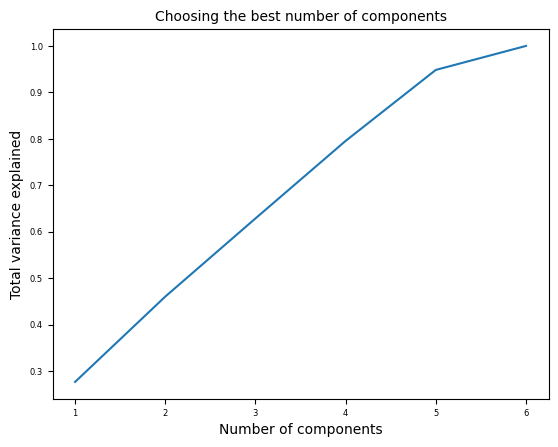

In [45]:
n_features = data_for_pca.shape[1]  # Number of features
components = np.arange(1, n_features + 1)
variances = []

for i in components:
    pca = PCA(n_components=i)
    pca.fit(data_for_pca)
    total_variance = np.sum(pca.explained_variance_ratio_)
    variances.append(total_variance)

# Plotting the total variance explained by each number of components
sns.lineplot(x=components, y=variances)
plt.xlabel('Number of components')
plt.ylabel('Total variance explained')
plt.title('Choosing the best number of components')
plt.show()


In [46]:
# Apply PCA with 5 components
pca = PCA(n_components=5)
train_pca = pd.DataFrame(pca.fit_transform(data_for_pca), index=games_train_filtered.index)

# Display the first few rows of the transformed dataset
train_pca.head()

,0,1,2,3,4
0,-0.318757,0.540794,-0.351634,-0.105734,-0.648117
1,-0.468520,-0.681643,-0.239246,-0.120383,0.028563
2,-0.381763,0.099780,-0.419163,-0.150948,-0.642133
3,-0.198478,-0.781743,-0.092438,-0.086750,0.400319
4,-0.248569,0.485400,0.221087,0.475897,0.143697


## Setting Different Experiments and Implementing them using Pipelines

**Experiment 1 (Exp1):**
- **Goal:** Evaluate performance with scaled numerical variables and PCA.
- **Preprocessing:**
  - Numeric variables: Scale and apply PCA (5 components).
  - Categorical variables: Impute missing values (constant value).
- **Model:** CatBoost
- **Purpose:** To understand the impact of PCA on model performance while keeping categorical variables imputed with a constant value.

**Experiment 2 (Exp2):**
- **Goal:** Assess model effectiveness with scaling, PCA, and different imputation strategies.
- **Preprocessing:**
  - Numeric variables: Impute missing values with mean, scale, and apply PCA (5 components).
  - Categorical variables: Impute missing values (constant value).
- **Model:** CatBoost
- **Purpose:** To determine the effect of mean imputation on numeric variables combined with PCA, while maintaining a constant imputation for categorical variables.

**Experiment 3 (Exp3):**
- **Goal:** Investigate the model's performance with scaled numerical variables without PCA.
- **Preprocessing:**
  - Numeric variables: Scale without applying PCA. Missing values are left as-is (not imputed).
  - Categorical variables: Impute missing values (constant value).
- **Model:** CatBoost
- **Purpose:** To explore how the model behaves with only scaling applied to numerical variables and how it handles unimputed missing numerical data, in contrast to categorical data imputation.



In [47]:
# Define categorical and numerical columns

numeric_cols = ['Required age', 'Price', 'DLC count', 'Positive', 'Negative',
                 'Average playtime forever', 'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks']
categorical_cols = ['Genres', 'Categories', 'Tags', 'Full audio languages']

In [52]:
# Prepare the features (X) and target (y)
from sklearn.preprocessing import OrdinalEncoder

# Check if the columns exist in 'games_train'
missing_cols = [col for col in categorical_cols if col not in games_train.columns]
if missing_cols:
    print("Missing columns in games_train:", missing_cols)
else:
    # If the columns are there, make sure they are included in X
    X = games_train_filtered[numeric_cols + categorical_cols]

    # Now, separate the features into numerical and categorical
    X_numerical = X[numeric_cols]
    X_categorical = X[categorical_cols]

    # Encode the categorical columns
    encoder = OrdinalEncoder()
    X_encoded_categorical = encoder.fit_transform(X_categorical)

    # Combine the numerical and encoded categorical columns
    X_combined = np.hstack((X_numerical, X_encoded_categorical))

In [53]:
from sklearn.preprocessing import OrdinalEncoder

# Separate the features into numerical and categorical
X_numerical = X[numeric_cols]
X_categorical = X[categorical_cols]

y = games_train_filtered['Peak CCU']

# Encode the categorical columns
encoder = OrdinalEncoder()
X_encoded_categorical = encoder.fit_transform(X_categorical)

# Combine back the numerical and encoded categorical columns
X_combined = np.hstack((X_numerical, X_encoded_categorical))

# Redefine the pipeline to only preprocess numerical columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, list(range(len(numeric_cols))))
    ])

In [54]:
# Set up for each three experiments with different preprocessing steps
# Experiment 1
numeric_transformer_exp1 = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5))
])
preprocessor_exp1 = ColumnTransformer(transformers=[
    ('num', numeric_transformer_exp1, list(range(len(numeric_cols))))
])
pipeline_exp1 = Pipeline(steps=[
    ('preprocessor', preprocessor_exp1),
    ('model', CatBoostRegressor(verbose=False))
])

# Experiment 2
numeric_transformer_exp2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5))
])
preprocessor_exp2 = ColumnTransformer(transformers=[
    ('num', numeric_transformer_exp2, list(range(len(numeric_cols))))
])
pipeline_exp2 = Pipeline(steps=[
    ('preprocessor', preprocessor_exp2),
    ('model', CatBoostRegressor(verbose=False))
])

# Experiment 3
numeric_transformer_exp3 = Pipeline(steps=[
    ('scaler', StandardScaler())
])
preprocessor_exp3 = ColumnTransformer(transformers=[
    ('num', numeric_transformer_exp3, list(range(len(numeric_cols))))
])
pipeline_exp3 = Pipeline(steps=[
    ('preprocessor', preprocessor_exp3),
    ('model', CatBoostRegressor(verbose=False))
])

Results for Experiment 1:
Mean R2 (Test): -0.14 (±0.26)
Mean MAE (Test): 7.35 (±-0.56)


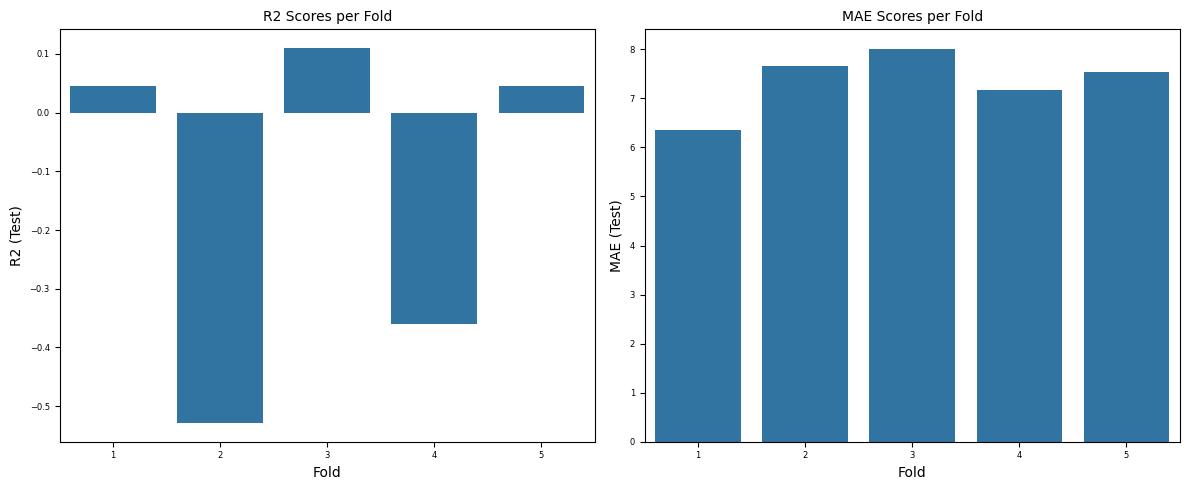

Results for Experiment 2:
Mean R2 (Test): -0.14 (±0.26)
Mean MAE (Test): 7.35 (±-0.56)


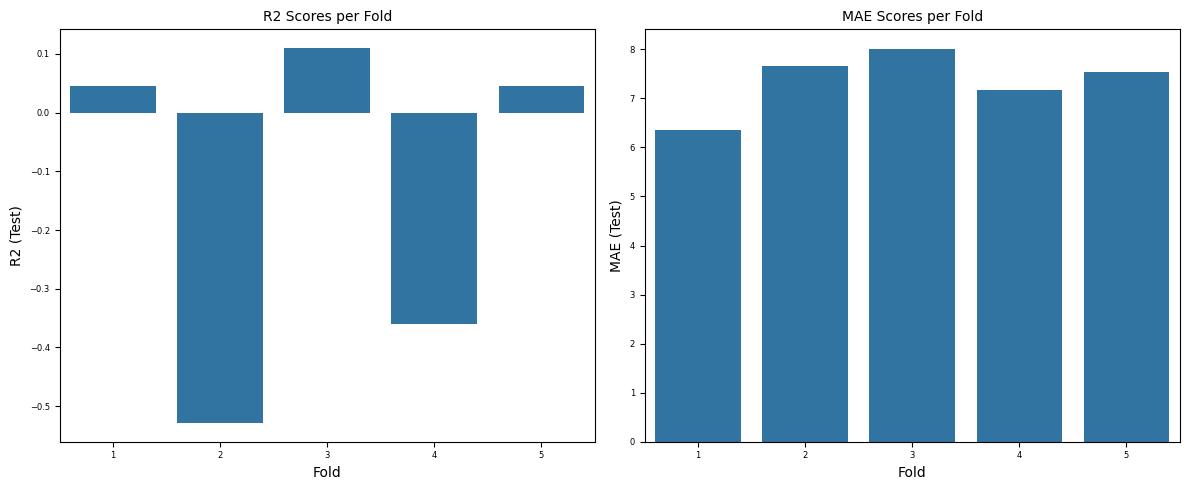

Results for Experiment 3:
Mean R2 (Test): -0.14 (±0.22)
Mean MAE (Test): 7.27 (±-0.58)


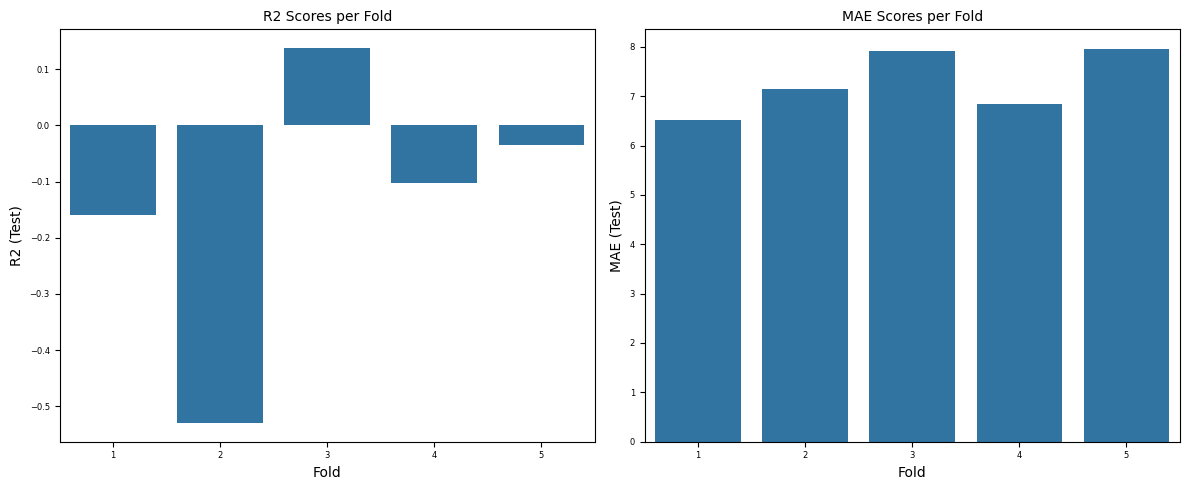

In [56]:

from sklearn.model_selection import KFold

# Define the KFold cross-validation strategy
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define a function to display the results of cross-validation
def display_results(cv_scores, experiment_name):
    test_r2_mean = cv_scores['test_r2'].mean()
    test_r2_sd = cv_scores['test_r2'].std()
    test_mae_mean = -cv_scores['test_neg_mean_absolute_error'].mean()
    test_mae_sd = -cv_scores['test_neg_mean_absolute_error'].std()

    print(f"Results for {experiment_name}:")
    print(f"Mean R2 (Test): {test_r2_mean:.2f} (±{test_r2_sd:.2f})")
    print(f"Mean MAE (Test): {test_mae_mean:.2f} (±{test_mae_sd:.2f})")

    # Plot
    df = pd.DataFrame({
        'Fold': range(1, len(cv_scores['test_r2']) + 1),
        'R2 (Test)': cv_scores['test_r2'],
        'MAE (Test)': -cv_scores['test_neg_mean_absolute_error']
    })

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.barplot(x='Fold', y='R2 (Test)', data=df)
    plt.title('R2 Scores per Fold')

    plt.subplot(1, 2, 2)
    sns.barplot(x='Fold', y='MAE (Test)', data=df)
    plt.title('MAE Scores per Fold')

    plt.tight_layout()
    plt.show()

# Run experiments using X_combined and y
cv_scores_exp1 = cross_validate(pipeline_exp1, X_combined, y, cv=kfold, scoring=['r2', 'neg_mean_absolute_error'])
display_results(cv_scores_exp1, "Experiment 1")

cv_scores_exp2 = cross_validate(pipeline_exp2, X_combined, y, cv=kfold, scoring=['r2', 'neg_mean_absolute_error'])
display_results(cv_scores_exp2, "Experiment 2")

cv_scores_exp3 = cross_validate(pipeline_exp3, X_combined, y, cv=kfold, scoring=['r2', 'neg_mean_absolute_error'])
display_results(cv_scores_exp3, "Experiment 3")

## Hyperparameter Calibration

In [57]:
import optuna

# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'iterations': trial.suggest_int('iterations', 50, 1000),
        'depth': trial.suggest_int('depth', 4, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_seed': 42  # Fixed seed for reproducibility
    }

    # Create the CatBoost model with suggested parameters
    model = CatBoostRegressor(**params, verbose=False)

    # Redefine your preprocessor for numerical features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=5))
    ])

    # Combine the preprocessor with the model in a pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', numeric_transformer),
        ('model', model)
    ])

    # Define cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=123)

    # Run cross-validation
    cv_scores = cross_validate(pipeline, X_combined, y, cv=kfold, scoring='neg_mean_absolute_error', n_jobs=-1)

    # Minimize the mean absolute error
    mean_mae = -cv_scores['test_score'].mean()
    return mean_mae

In [58]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Output the best parameters
print('Best trial:', study.best_trial.params)

[I 2024-01-21 18:21:21,511] A new study created in memory with name: no-name-ec6deff0-c39f-4b3b-8a11-33d6b0b8f39b
[I 2024-01-21 18:22:44,010] Trial 0 finished with value: 7.735768426232548 and parameters: {'iterations': 329, 'depth': 15, 'learning_rate': 0.16420606592970624}. Best is trial 0 with value: 7.735768426232548.
[I 2024-01-21 18:22:47,524] Trial 1 finished with value: 7.6676147054325465 and parameters: {'iterations': 964, 'depth': 5, 'learning_rate': 0.08922154048479274}. Best is trial 1 with value: 7.6676147054325465.
[I 2024-01-21 18:22:50,899] Trial 2 finished with value: 7.611125064076823 and parameters: {'iterations': 673, 'depth': 7, 'learning_rate': 0.09842479941405373}. Best is trial 2 with value: 7.611125064076823.
[I 2024-01-21 18:22:57,319] Trial 3 finished with value: 7.766256240581929 and parameters: {'iterations': 405, 'depth': 11, 'learning_rate': 0.1632884233092483}. Best is trial 2 with value: 7.611125064076823.
[I 2024-01-21 18:23:30,632] Trial 4 finished wi

Best trial: {'iterations': 134, 'depth': 15, 'learning_rate': 0.016814753970167892}


Best Trial Parameters: {'iterations': 134, 'depth': 15, 'learning_rate': 0.016814753970167892}


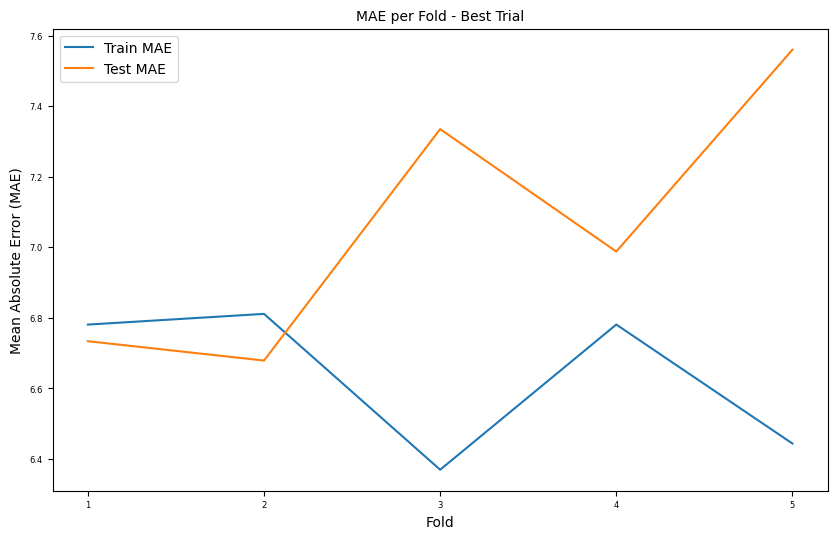

In [59]:
# Run the best trial and collect detailed results
def run_best_trial(study, X, y):
    best_params = study.best_trial.params
    print("Best Trial Parameters:", best_params)

    model = CatBoostRegressor(**best_params, verbose=False)

    # Redefine the preprocessor for numerical features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=5))
    ])

    # Combine the preprocessor with the model in a pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', numeric_transformer),
        ('model', model)
    ])

    # Define cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)

    # Run cross-validation
    cv_scores = cross_validate(pipeline, X_combined, y, cv=kfold, scoring='neg_mean_absolute_error', return_train_score=True)

    return cv_scores

# Run the best trial
cv_scores_best = run_best_trial(study, X_combined, y)

# Plotting the results
folds = range(1, 6)
plt.figure(figsize=(10, 6))
plt.plot(folds, -cv_scores_best['train_score'], label='Train MAE')
plt.plot(folds, -cv_scores_best['test_score'], label='Test MAE')
plt.xlabel('Fold')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE per Fold - Best Trial')
plt.xticks(folds)
plt.legend()
plt.show()

## Validation

In [60]:
from sklearn.metrics import mean_absolute_error

# Extract the best parameters from the Optuna study
best_params = study.best_trial.params
print("Best parameters:", best_params)

# Create a new CatBoostRegressor with these parameters
final_model = CatBoostRegressor(**best_params, verbose=False, cat_features=categorical_cols)

# Define the preprocessor for numerical features
numeric_transformer_final = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5))
])

# Combine the preprocessors in a ColumnTransformer
preprocessor_final = ColumnTransformer(transformers=[
    ('num', numeric_transformer_final, list(range(len(numeric_cols))))
    # Add other transformers here if needed for categorical data
])

# Create the final pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_final),
    ('model', final_model)
])


Best parameters: {'iterations': 134, 'depth': 15, 'learning_rate': 0.016814753970167892}


## Evaluate on the Test Set

In [62]:
# Create a new CatBoostRegressor without specifying cat_features
final_model = CatBoostRegressor(**best_params, verbose=False)

# Define the preprocessor for numerical features
numeric_transformer_final = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5))
])

# Define the preprocessor for categorical features
categorical_transformer_final = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the preprocessors in a ColumnTransformer
preprocessor_final = ColumnTransformer(transformers=[
    ('num', numeric_transformer_final, numeric_cols),
    ('cat', categorical_transformer_final, categorical_cols)
])

# Create the final pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_final),
    ('model', final_model)
])

In [63]:
# Load the test set

games_test = pd.read_csv("games_test.csv")

# Apply the same transformations to the test set as you did for the training set
games_test['Supported languages'] = games_test['Supported languages'].apply(safe_eval)
games_test['Full audio languages'] = games_test['Full audio languages'].apply(concat_languages)
games_test['Genres'] = transform_column(games_test['Genres'])
games_test['Categories'] = transform_column(games_test['Categories'])
games_test['Tags'] = transform_column(games_test['Tags'])

# Impute missing numeric values
numeric_cols_test = games_test.select_dtypes(include=[np.number])
imputed_data_test = iterative_imputer.transform(numeric_cols_test)
imputed_df_test = pd.DataFrame(imputed_data_test, columns=numeric_cols_test.columns)
games_test[numeric_cols_test.columns] = imputed_df_test

# Drop the same columns from the test set as the training set
drop_columns = ['Reviews', 'Metacritic url', 'Notes', 'AppID', 'Name', 'Estimated owners', 'Support url', 'Movies', 'Header image', 'Website', 'Support email', 'Screenshots', 'Metacritic score', 'User score', 'Achievements', 'Recommendations']
games_test_filtered = games_test.drop(columns=drop_columns)

# Clean the text data in the test set
games_test_filtered['cleaned_text'] = games_test_filtered['About the game'].apply(clean_text)
games_test_filtered['cleaned_text'] = games_test_filtered['cleaned_text'].fillna('no text')

# Ensure that the columns for PCA are consistent with the training set
test_pca_columns = [col for col in pca_columns if col in games_test_filtered.columns]

# Apply scaling
games_test_filtered[test_pca_columns] = scaler.transform(games_test_filtered[test_pca_columns])


# Apply PCA
test_pca_data = pca.transform(games_test_filtered[test_pca_columns])
test_pca = pd.DataFrame(test_pca_data, index=games_test_filtered.index)

# Prepare X_test and y_test
X_test = games_test_filtered[numeric_cols + categorical_cols]
y_test = games_test_filtered['Peak CCU']

# Final model validation using the best parameters
best_params = study.best_trial.params
final_model = CatBoostRegressor(**best_params, verbose=False, cat_features=categorical_cols)

# Fit the model on the entire training set
final_model.fit(X_train, y_train)

# Fit the model on the entire training set (ensure X_train is preprocessed if needed)
final_pipeline.fit(X_train, y_train)

# Predict on the test set (ensure X_test is preprocessed if needed)
y_pred = final_pipeline.predict(X_test)

# Calculate and print the Mean Absolute Error on the test set
test_mae = mean_absolute_error(y_test, y_pred)
print("Validation MAE on Test Set:", test_mae)

Validation MAE on Test Set: 196.96624758864223


## Model Persistence using Joblib

In [64]:
import joblib

# Save the model to a file
model_filename = 'final_pipeline_model.joblib'
joblib.dump(final_pipeline, model_filename)

['final_pipeline_model.joblib']

In [69]:
import json

def load_model(path):
    """ Load the trained model from a file. """
    return joblib.load(path)

def load_json(path):
    """ Load data from a JSON file. """
    with open(path, 'r') as f:
        data = json.load(f)
    return data

def predict(model_path, input_path):
    """ Make predictions using the loaded model and input data. """
    model = load_model(model_path)
    payload = load_json(input_path)
    df = pd.DataFrame.from_dict(payload, orient='index').transpose()
    return model.predict(df)

